In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import json
import math
from statsmodels.nonparametric.smoothers_lowess import lowess
import numpy as np
from scipy.signal import argrelmax
from scipy.signal import argrelmin
from scipy import signal
import re
from scipy import stats
import pandas as pd
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, BaggingRegressor
from sklearn.metrics import classification_report
import random
from sklearn import metrics
from scipy.stats import mannwhitneyu

# Все функции для получения сигналов и подсчета статистик

In [3]:
def filter_extremums(value_maxes, frame_maxes, value_mines, frame_mines): # Эта функция которая удаляет лишние максимумы и минимумы, после её применения они будут строго чередоваться 
    #                                                                      (один минимум дальше один максимум и так далее. Оканчиваться будет минимумом)
    min_i = 0
    max_i = 0
    result_value = []
    result_frame = []
   
    for i in range(len(value_maxes)):

        
        if min_i == 0:
            min_to_add = [x for x in frame_mines if x < frame_maxes[0]]
            min_i = len(min_to_add)

        else:
            min_to_add = [x for x in frame_mines if x < frame_maxes[max_i]][min_i:]
            min_i += len(min_to_add)
            

        max_to_add = [x for x in frame_maxes if x < frame_mines[min_i]][max_i:]
        
        max_i += len(max_to_add)
        

        min_val = 10000
        max_val = 0

        for element in max_to_add:
            indices = np.where(frame_maxes == element)[0]
            if value_maxes[indices] > max_val:
                max_val = float(value_maxes[indices])
                max_frame = element

       

        for element in min_to_add:
            indices = np.where(frame_mines == element)[0]
            if value_mines[indices] < min_val:
                min_val = float(value_mines[indices])
                min_frame = element

        result_value.extend((min_val, max_val))
        result_frame.extend((min_frame, max_frame))
        

        if max(max_to_add) == frame_maxes[-1]:
            min_to_add = [x for x in frame_mines if x > frame_maxes[-1]]
            result_frame.append(frame_mines[-1])
            result_value.append(value_mines[-1])

            value_maxes = [x for x in  result_value if result_value.index(x)%2!=0]
            frame_maxes = [x for x in  result_frame if result_frame.index(x)%2!=0]

            value_mines = [x for x in  result_value if result_value.index(x)%2==0]
            frame_mines = [x for x in  result_frame if result_frame.index(x)%2==0]

            
            return value_maxes, frame_maxes, value_mines, frame_mines

In [4]:
def cut_signal (start_cut, end_cut, frame, value, mines, maxes): # Функция которая обрезает сигнал
    
   end_cut = len(frame) - end_cut

    # plt.plot(frame, value)
    # plt.show()

   frame_mines = frame[mines]
   frame_maxes = frame[maxes]

   value_mines = value[mines]
   value_maxes = value[maxes]

   closet_number_1 = int(min(frame_mines, key=lambda x: abs(x - start_cut)))
   closet_number_2 = int(min(frame_mines, key=lambda x: abs(x - end_cut)))


   new_frame = np.arange(0, -closet_number_1 + closet_number_2 + 1)
   new_value = value[closet_number_1 : closet_number_2 + 1]

   new_mines = np.array(mines) - closet_number_1
   
   new_mines = new_mines[new_mines <= closet_number_2 - closet_number_1]
   new_mines = new_mines[new_mines >= 0].astype(int)
   
   new_maxes = np.array(maxes) - closet_number_1
   new_maxes = new_maxes[new_maxes <= closet_number_2 - closet_number_1]
   new_maxes = new_maxes[new_maxes >= 0].astype(int)

   value_maxes = new_value[new_maxes]
   frame_maxes = new_frame[new_maxes]

   value_mines = new_value[new_mines]
   frame_mines= new_frame[new_mines]
   
   return value_mines, frame_mines, value_maxes, frame_maxes, new_frame, new_value

In [5]:
def prepare_signal1(path,hand,task,smooth,ordermin,ordermax,fs, graphics): #функция для построения сигналов

    data = json.load(open(path))

    frame, znach = draw_signal (data, task, hand)

    plt.plot(frame, znach)
    plt.show()


    filtered = lowess(znach, frame, is_sorted=True, frac=smooth, it=0)  # 0.02

    frame, value = np.array(filtered[:, 0]), np.array(filtered[:, 1])
    maxTemp = argrelmax(value, order=ordermax)
    minTemp = argrelmin(value, order=ordermin)
    mines = []
    maxes = []

    for maxi in maxTemp[0]:
        if value[maxi] > 0:
            maxes.append(maxi)

    for mini in minTemp[0]:
        if value[mini] > 0:
            mines.append(mini)
  

    value_mines, frame_mines, value_maxes, frame_maxes, new_frame, new_value = cut_signal(200,200, frame, value, mines, maxes)

    
    return new_frame, new_value, value_maxes, frame_maxes, value_mines, frame_mines

In [6]:
file = 'C:\\Parkinson\\patient\\0_stage\\Patient89\\hand\\leapRecording1_L_m2_patient89.json'
a = prepare_signal1(
    file,
    'left hand',
    1,
    smooth=0.007,
    ordermin=15,
    ordermax=15,
    fs=100,
    graphics=True
)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Parkinson\\patient\\0_stage\\Patient89\\hand\\leapRecording1_L_m2_patient89.json'

In [7]:
def draw_signal (data, task, hand): # Функция которая отрисовывает исходные данные
    znach= []
    frame = []
    if task==1:
        for i in range(len(data)):
            if hand in data[i].keys():

                sum_sqr = (float(data[i][hand]['FORE_TIP']['X1']) - float(data[i][hand]['THUMB_TIP']['X1'])) ** 2 \
                + (float(data[i][hand]['FORE_TIP']['Y1']) -float(data[i][hand]['THUMB_TIP']['Y1'])) ** 2 \
                + (float(data[i][hand]['FORE_TIP']['Z1']) -float(data[i][hand]['THUMB_TIP']['Z1'])) ** 2
                distance = math.sqrt(sum_sqr)
                znach.append(distance)
                frame.append(data[i]['frame'])

    if task == 2:
        for i in range(len(data)):
            if hand in data[i].keys():

                sum_sqr = (float(data[i][hand]['MIDDLE_TIP']['X1']) - float(data[i][hand]['CENTRE']['X'])) ** 2 \
                + (float(data[i][hand]['MIDDLE_TIP']['Y1']) -float(data[i][hand]['CENTRE']['Y'])) ** 2 \
                + (float(data[i][hand]['MIDDLE_TIP']['Z1']) -float(data[i][hand]['CENTRE']['Z'])) ** 2
                distance = math.sqrt(sum_sqr)
                znach.append(distance)
                frame.append(data[i]['frame'])

    if task == 3:
        for i in range(len(data)):
            if hand in data[i].keys():

                znach.append(math.sqrt(float(data[i][hand]['LITTLE_DIP']['Z3'])**2\
                                       +float(data[i][hand]['LITTLE_DIP']['X3'])**2\
                                       +float(data[i][hand]['LITTLE_DIP']['Y3'])**2))

                frame.append(data[i]['frame'])


    frame = np.array(frame) - frame[0] # в случае если начало записи пустое и фреймы начинаются не с 0.
    
    return frame, np.array(znach)

In [8]:
def prepare_signal(path,hand,task,smooth,ordermin,ordermax,fs, graphics): #функция для построения сигналов

    data = json.load(open(path))

    frame, znach = draw_signal (data, task, hand)

   
    filtered = lowess(znach, frame, is_sorted=True, frac=smooth, it=0)  # 0.02

    frame, value = np.array(filtered[:, 0]), np.array(filtered[:, 1])
    maxTemp = argrelmax(value, order=ordermax)
    minTemp = argrelmin(value, order=ordermin)
    mines = []
    maxes = []


    for maxi in maxTemp[0]:
        if value[maxi] > 0:
            maxes.append(maxi)

    for mini in minTemp[0]:
        if value[mini] > 0:
            mines.append(mini)
            
    time = frame / fs



    value_mines, frame_mines, value_maxes, frame_maxes, new_frame, new_value = cut_signal(200,200, frame, value, mines, maxes)

    value_maxes, frame_maxes, value_mines, frame_mines =  filter_extremums(value_maxes, frame_maxes, value_mines, frame_mines)

    if graphics:
        
      
        plt.plot(new_frame, new_value, '-')
        plt.plot(frame_maxes, value_maxes, 'ro')
        plt.plot(frame_mines, value_mines, 'bo')
        plt.show()

    return new_frame, new_value, value_maxes, frame_maxes, value_mines, frame_mines

In [9]:
def amplitude_min_max(maxi,mini): # Функция для подсчёта амплитуды
    amp = []
    j = 0
    for i in maxi:
        amp.extend((i - mini[j] , i - mini[j+1]))
        if i - mini[j] < 0 or i - mini[j+1] <0:
            print(i - mini[j] ,  i - mini[j+1] )
        j+=1

    z = [x for x in amp if x > 0.15*max(amp)]
    return np.mean(z), z

In [10]:
def amplitude_median( maxi,mini):  # Функция для подсчёта амплитуды через медиану
    return np.round(np.median(maxi)-np.median(mini),3)

In [11]:
def frequency (fs, frames, z):
                                         # Функция для подсчёта частоты
    time = len(frames)/fs
    return np.round(len(z)/(2*time),3)

In [14]:
def add_to_task (task, stadia, patient, gender,  m, hand,  amp_min_max, amp_median , freq, number): #функция добаво
    if len(task) !=0:
        newrow = [number, m,stadia[0],patient + ' ' + m + ' ' + hand, gender, hand, amp_min_max, amp_median , freq]
        task = np.vstack([task, newrow])
    else:
        task = np.array([number, m,stadia[0],patient + ' ' + m + ' ' + hand, gender, hand, amp_min_max, amp_median, freq])
    return task

In [37]:
def patients (stadia, path, graph, f, stats,  task1, task2,task3, problems, inf):
    
    for gender in os.listdir(os.path.join(path,stadia)): #перебираем пациентов
        gender_path = path+ '\\' + stadia +'\\'+gender
        for patient in os.listdir(gender_path):
            patient_path = gender_path +'\\'+ patient+ '\\hand' # переходим в папку hand
            for record in (os.listdir(patient_path)): # проходим по каждой записи

                if record.find('json')>0 and  record.find('TR') < 0: # выбираем только json и исключаем записи тремора
                    h= re.search('_[A-Z]_',record ).group(0)[1] # Определяем на какую руку было упражнение
                    if h == 'L':
                        hand = 'left hand'
                    else:
                        hand = 'right hand'

                    m = re.search('_[a-z]\d_',record ).group(0)[1:3] 
                    zadacha = re.search('\d_[A-Z]',record ).group(0)[0] # Определяем какое  было упражнение
                    
                    number = re.search('[0-9]+', patient).group(0)
            
                    file = os.path.join(patient_path,record)
                    if inf:
                        print(record,patient, stadia)
                    new_frame, new_value, value_maxes, frame_maxes, value_mines, frame_mines = prepare_signal(file,hand,int(zadacha), \
                                                            smooth=0.007,ordermin=15,
                                                                    ordermax=15, fs = f ,graphics=graph)
                    if len(new_frame)==0:
                        problems.append(record) #если файл пустой, запишем его название 
                        
                    if stats and len(new_frame)>0:
                        amp_min_max, amp = amplitude_min_max (value_maxes,  value_mines)
                        amp_median = amplitude_median (value_maxes, value_mines)
                        freq = frequency (f, new_frame, amp)

                    if zadacha == '1':
                        task1 = add_to_task(task1, stadia, patient, gender,m, hand, float( amp_min_max ),float( amp_median ), float(freq), int(number))
                    
                    if zadacha == '2':
                        task2 = add_to_task(task2, stadia, patient,gender, m, hand, float( amp_min_max ),float( amp_median ), float(freq), int(number))
                        
                    if zadacha == '3':
                        task3 = add_to_task(task3, stadia, patient, gender, m, hand,float( amp_min_max ),float( amp_median ), float(freq), int(number))
    return task1, task2,task3, problems


In [15]:
def signal_processing(path,stats = True, graph=False, fs = 100, inf = True ):
    task1 = []
    task2 = []
    task3 = []
    problems = []
    for stadia in os.listdir(path):
        if stadia == '0_stage':
            task1, task2, task3, problems = patients (stadia, path, graph, fs, stats,  task1, task2, task3, problems, inf)
        if stadia == '1_stage':
            task1, task2, task3, problems = patients (stadia, path, graph, fs, stats,  task1, task2, task3, problems, inf)
        if stadia == '2_stage':
            task1, task2, task3, problems = patients (stadia, path, graph, fs, stats,  task1, task2, task3, problems,inf)
        if stadia == '3_stage':
            task1, task2, task3, problems = patients (stadia, path, graph, fs, stats,   task1, task2, task3, problems,inf)
    return task1, task2, task3, problems

# Обработка сигналов

In [17]:
path = 'C:\\Parkinson\\processed'

In [38]:
a1,a2,a3,a4 = signal_processing(path, graph = False, inf = True)

leapRecording1_L_m1_patient10.json Patient10 0_stage


C:\Users\Asus\AppData\Local\Temp\ipykernel_6860\185454126.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  max_val = float(value_maxes[indices])
C:\Users\Asus\AppData\Local\Temp\ipykernel_6860\185454126.py:39: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  min_val = float(value_mines[indices])


leapRecording1_L_m2_patient10.json Patient10 0_stage
leapRecording1_L_m3_patient10.json Patient10 0_stage
leapRecording1_L_m4_patient10.json Patient10 0_stage
leapRecording1_L_m5_patient10.json Patient10 0_stage
leapRecording1_R_m1_patient10.json Patient10 0_stage
leapRecording1_R_m2_patient10.json Patient10 0_stage
leapRecording1_R_m3_patient10.json Patient10 0_stage
leapRecording1_R_m4_patient10.json Patient10 0_stage
leapRecording1_R_m5_patient10.json Patient10 0_stage
leapRecording2_L_m1_patient10.json Patient10 0_stage
leapRecording2_L_m2_patient10.json Patient10 0_stage
leapRecording2_L_m3_patient10.json Patient10 0_stage
leapRecording2_L_m4_patient10.json Patient10 0_stage
leapRecording2_L_m5_patient10.json Patient10 0_stage
leapRecording2_R_m1_patient10.json Patient10 0_stage
leapRecording2_R_m2_patient10.json Patient10 0_stage
leapRecording2_R_m3_patient10.json Patient10 0_stage
leapRecording2_R_m4_patient10.json Patient10 0_stage
leapRecording2_R_m5_patient10.json Patient10 0

In [39]:
df_task1 = pd.DataFrame(a1, columns = ['Индекс пациента', 'Номер эксперимента','Таргет', 'Запись','Гендер',  'Рука',  'Амплитуда_min_max', 'Амплитуда_median', 'Частота'])
df_task1 = df_task1.astype ({'Частота': float,'Амплитуда_min_max': float, 'Амплитуда_median':float , 'Таргет': int, 'Индекс пациента':int})

df_task2 = pd.DataFrame(a2, columns = ['Индекс пациента', 'Номер эксперимента','Таргет', 'Запись', 'Гендер', 'Рука',  'Амплитуда_min_max', 'Амплитуда_median', 'Частота'])
df_task2 = df_task2.astype ({'Частота': float,'Амплитуда_min_max': float, 'Амплитуда_median':float , 'Таргет': int, 'Индекс пациента':int})

df_task3 = pd.DataFrame(a3, columns = ['Индекс пациента', 'Номер эксперимента','Таргет', 'Запись', 'Гендер', 'Рука',  'Амплитуда_min_max', 'Амплитуда_median', 'Частота'])
df_task3 = df_task3.astype ({'Частота': float,'Амплитуда_min_max': float, 'Амплитуда_median':float , 'Таргет': int, 'Индекс пациента':int})


In [40]:
merged_df= pd.merge(df_task1, df_task2,   on=['Запись','Гендер', 'Рука', 'Таргет', 'Индекс пациента','Номер эксперимента'], how='inner')
merged_df = pd.merge(merged_df, df_task3,   on=['Запись','Гендер',  'Рука', 'Таргет', 'Индекс пациента','Номер эксперимента'], how='inner')
merged_df = merged_df.rename(columns={'Амплитуда_min_max_x': 'Амп_min_max_1', 'Амплитуда_median_x': 'Амплитуда_median_1', 'Частота_x': 'Частота_1','Амплитуда_min_max_y': 'Амп_min_max_2', 'Амплитуда_median_y': 'Амплитуда_median_2', 'Частота_y': 'Частота_2','Амплитуда_min_max': 'Амп_min_max_3', 'Амплитуда_median': 'Амплитуда_median_3', 'Частота': 'Частота_3'})
merged_df[merged_df['Амп_min_max_1']>0]

,Индекс пациента,Номер эксперимента,Таргет,Запись,Гендер,Рука,Амп_min_max_1,Амплитуда_median_1,Частота_1,Амп_min_max_2,Амплитуда_median_2,Частота_2,Амп_min_max_3,Амплитуда_median_3,Частота_3
0,10,m1,0,Patient10 m1 left hand,female,left hand,78.002463,79.073,3.531,67.833390,68.533,1.798,0.630107,0.638,2.022
1,10,m2,0,Patient10 m2 left hand,female,left hand,73.684450,75.061,4.035,64.908213,66.930,2.205,0.666000,0.673,2.197
2,10,m3,0,Patient10 m3 left hand,female,left hand,60.637241,61.987,3.765,67.103081,70.479,2.010,0.669910,0.670,2.276
3,10,m4,0,Patient10 m4 left hand,female,left hand,58.696794,60.421,3.644,47.613902,50.527,2.375,0.658075,0.665,2.279
4,10,m5,0,Patient10 m5 left hand,female,left hand,62.089581,64.734,3.487,52.822951,55.175,2.465,0.675774,0.677,2.402
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,82,m2,3,Patient82 m2 right hand,male,right hand,70.668184,68.494,1.189,63.573793,63.822,1.099,0.575887,0.579,1.207
204,86,m1,3,patient86 m1 left hand,male,left hand,87.677666,88.670,0.976,61.147581,60.328,0.922,0.722626,0.721,0.930
205,86,m2,3,patient86 m2 left hand,male,left hand,80.538938,80.542,1.718,19.082070,18.793,3.095,0.468630,0.526,2.112
206,86,m1,3,patient86 m1 right hand,male,right hand,36.418871,36.390,1.386,66.001332,66.290,0.998,0.622252,0.582,0.927


In [41]:
df_zdorov = merged_df[merged_df['Таргет'] == 0]
df_bolen = merged_df[(merged_df['Таргет']== 1) | (merged_df['Таргет']== 2) | (merged_df['Таргет'] == 3)]
df_bolen.loc[:,'Таргет'] = 1
df_1stage = merged_df[merged_df['Таргет']== 1]
df_2stage = merged_df[merged_df['Таргет']== 2]
df_3stage = merged_df[merged_df['Таргет']== 3]


In [148]:
df_zdorov

Index(['Индекс пациента', 'Номер эксперимента', 'Таргет', 'Запись',
       'Амп_min_max_1', 'Амплитуда_median_1', 'Частота_1', 'Амп_min_max_2',
       'Амплитуда_median_2', 'Частота_2', 'Амп_min_max_3',
       'Амплитуда_median_3', 'Частота_3'],
      dtype='object')

In [42]:
df_zdorov_bolen = pd.concat([df_zdorov,df_bolen])

df_zdorov_1stage = pd.concat([df_zdorov,df_1stage] )

df_23stage = pd.concat([df_3stage,df_2stage])
df_23stage['Таргет'] = 2

df_zdorov_23stage = pd.concat([df_zdorov,df_23stage])

df_1stage_23stage = pd.concat([df_1stage,df_23stage])

# Гистограммы 

In [44]:
df_zdorov_usred_po_rukam = df_zdorov.groupby(['Индекс пациента', 'Номер эксперимента']).agg({'Гендер': 'max', 'Таргет':'max','Амп_min_max_1': 'mean', 'Амплитуда_median_1': 'mean', 'Частота_1': 'mean',
    'Амп_min_max_2': 'mean', 'Амплитуда_median_2': 'mean', 'Частота_2': 'mean',
    'Амп_min_max_3': 'mean', 'Амплитуда_median_3': 'mean' ,'Частота_3': 'mean'})
df_zdorov_usred_po_rukam = df_zdorov_usred_po_rukam[df_zdorov_usred_po_rukam['Частота_1']>1.5]

df_1_stage_usred_po_rukam = df_1stage.groupby(['Индекс пациента', 'Номер эксперимента']).agg({ 'Гендер': 'max','Таргет':'max','Амп_min_max_1': 'mean', 'Амплитуда_median_1': 'mean', 'Частота_1': 'mean',
    'Амп_min_max_2': 'mean', 'Амплитуда_median_2': 'mean', 'Частота_2': 'mean',
    'Амп_min_max_3': 'mean', 'Амплитуда_median_3': 'mean' ,'Частота_3': 'mean'})

df_2_stage_usred_po_rukam = df_2stage.groupby(['Индекс пациента', 'Номер эксперимента']).agg({'Гендер': 'max', 'Таргет':'max','Амп_min_max_1': 'mean', 'Амплитуда_median_1': 'mean', 'Частота_1': 'mean',
    'Амп_min_max_2': 'mean', 'Амплитуда_median_2': 'mean', 'Частота_2': 'mean',
    'Амп_min_max_3': 'mean', 'Амплитуда_median_3': 'mean' ,'Частота_3': 'mean'})

df_3_stage_usred_po_rukam = df_3stage.groupby(['Индекс пациента', 'Номер эксперимента']).agg({'Гендер': 'max', 'Таргет':'max','Амп_min_max_1': 'mean', 'Амплитуда_median_1': 'mean', 'Частота_1': 'mean',
    'Амп_min_max_2': 'mean', 'Амплитуда_median_2': 'mean', 'Частота_2': 'mean',
    'Амп_min_max_3': 'mean', 'Амплитуда_median_3': 'mean' ,'Частота_3': 'mean'})

In [47]:
df_2_stage_usred_po_rukam

Гендер  Таргет  Амп_min_max_1  \
Индекс пациента Номер эксперимента                                  
43              m2                    male       2      11.580951   
49              m1                    male       2      34.065487   
                m2                    male       2      32.496500   
53              m1                  female       2       9.430297   
                m2                  female       2       9.341296   
54              m1                    male       2      10.512283   
                m2                    male       2      12.618724   

                                    Амплитуда_median_1  Частота_1  \
Индекс пациента Номер эксперимента                                  
43              m2                             10.1715     3.7050   
49              m1                             34.3710     4.0365   
                m2                             35.2375     3.3170   
53              m1                              9.3365     3.1495   
                m2                              9.1320     2.8625   
54              m1                              9.4545     2.1350   
                m2                             13.4495     3.0215   

                                    Амп_min_max_2  Амплитуда_median_2  \
Индекс пациента Номер эксперимента                                      
43              m2                      42.260138             42.1960   
49              m1                      47.278983             46.8685   
                m2                      53.089992             53.3905   
53              m1                      10.422714              9.8580   
                m2                      22.674947             22.1870   
54              m1                      64.971066             65.6540   
                m2                      62.758955             63.3930   

                                    Частота_2  Амп_min_max_3  \
Индекс пациента Номер эксперимента                             
43              m2                     3.2350       0.438715   
49              m1                     2.7090       0.703681   
                m2                     2.7930       0.622011   
53              m1                     2.9575       0.291240   
                m2                     2.6805       0.493013   
54              m1                     2.1340       0.466919   
                m2                     2.2205       0.531075   

                                    Амплитуда_median_3  Частота_3  
Индекс пациента Номер эксперимента                                 
43              m2                              0.4420     2.8290  
49              m1                              0.7140     2.4725  
                m2                              0.6415     2.9920  
53              m1                              0.2840     2.0945  
                m2                              0.5200     2.2750  
54              m1                              0.4725     2.7170  
                m2                              0.5400     2.7230

In [46]:
df_zdorov_usred_po_m = df_zdorov.groupby(['Индекс пациента', 'Рука']).agg({ 'Гендер': 'max', 'Таргет':'max','Амп_min_max_1': 'mean', 'Амплитуда_median_1': 'mean', 'Частота_1': 'mean',
    'Амп_min_max_2': 'mean', 'Амплитуда_median_2': 'mean', 'Частота_2': 'mean',
    'Амп_min_max_3': 'mean', 'Амплитуда_median_3': 'mean' ,'Частота_3': 'mean'})

df_1_stage_usred_po_m = df_1stage.groupby(['Индекс пациента', 'Рука']).agg({ 'Гендер': 'max', 'Таргет':'max','Амп_min_max_1': 'mean', 'Амплитуда_median_1': 'mean', 'Частота_1': 'mean',
    'Амп_min_max_2': 'mean', 'Амплитуда_median_2': 'mean', 'Частота_2': 'mean',
    'Амп_min_max_3': 'mean', 'Амплитуда_median_3': 'mean' ,'Частота_3': 'mean'})

df_2_stage_usred_po_m = df_2stage.groupby(['Индекс пациента', 'Рука']).agg({ 'Гендер': 'max', 'Таргет':'max','Амп_min_max_1': 'mean', 'Амплитуда_median_1': 'mean', 'Частота_1': 'mean',
    'Амп_min_max_2': 'mean', 'Амплитуда_median_2': 'mean', 'Частота_2': 'mean',
    'Амп_min_max_3': 'mean', 'Амплитуда_median_3': 'mean' ,'Частота_3': 'mean'})

df_3_stage_usred_po_m = df_3stage.groupby(['Индекс пациента', 'Рука']).agg({ 'Гендер': 'max', 'Таргет':'max','Амп_min_max_1': 'mean', 'Амплитуда_median_1': 'mean', 'Частота_1': 'mean',
    'Амп_min_max_2': 'mean', 'Амплитуда_median_2': 'mean', 'Частота_2': 'mean',
    'Амп_min_max_3': 'mean', 'Амплитуда_median_3': 'mean' ,'Частота_3': 'mean'})

In [50]:
def histo (df_zdorov, df_1_stage, df_2_stage, df_3_stage, data):
    plt.figure(figsize=(10, 10))
    plt.subplot(2,2,1)
    plt.title('Здоровые', fontsize=12)
    sns.histplot(df_zdorov[data].values, kde = True)
    
    plt.subplot(2,2,2)
    plt.title('1_стадия', fontsize=12)
    sns.histplot(df_1_stage[data].values, kde = True)
   
    plt.subplot(2,2,3)
    plt.title('2_стадия', fontsize=12)
    sns.histplot(df_2_stage[data].values, kde = True)
    
    plt.subplot(2,2,4)
    plt.title('3_стадия', fontsize=12)
    sns.histplot(df_3_stage[data].values, kde = True)
   
    plt.subplots_adjust(hspace=0.2, wspace=0.3)
    plt.suptitle(f'Сравнение {data} по стадиям ', fontsize=16)
    plt.show()

    plt.figure ()
    sns.kdeplot(df_zdorov[data].values, label = 'Здоров')
    sns.kdeplot(df_1_stage[data].values, label = '1 стадия')
    sns.kdeplot(df_2_stage[data].values,  label = '2 стадия')
    sns.kdeplot(df_3_stage[data].values,  label = '3 стадия')
    plt.legend()
    plt.show()
    print('\nСравнение здоров/1стадия', 'p_val_Мано-Уитни',mannwhitneyu(df_zdorov[data].values, df_1_stage[data].values)[1], 'p_val_Стьюдент', stats.ttest_ind(df_zdorov[data].values, df_1_stage[data].values, equal_var=False)[1])
    print('\nСравнение здоров/2стадия', 'p_val_Мано-Уитни',mannwhitneyu(df_zdorov[data].values, df_2_stage[data].values)[1], 'p_val_Стьюдент', stats.ttest_ind(df_zdorov[data].values, df_2_stage[data].values, equal_var=False)[1])
    print('\nСравнение здоров/3стадия', 'p_val_Мано-Уитни',mannwhitneyu(df_zdorov[data].values, df_3_stage[data].values)[1], 'p_val_Стьюдент', stats.ttest_ind(df_zdorov[data].values, df_3_stage[data].values, equal_var=False)[1])
    print('\nСравнение 1стадия/2стадия', 'p_val_Мано-Уитни',mannwhitneyu(df_1_stage[data].values, df_2_stage[data].values)[1], 'p_val_Стьюдент', stats.ttest_ind(df_1_stage[data].values, df_2_stage[data].values, equal_var=False)[1])
    print('\nСравнение 1стадия/3стадия','p_val_Мано-Уитни',mannwhitneyu(df_1_stage[data].values, df_3_stage[data].values)[1], 'p_val_Стьюдент', stats.ttest_ind(df_1_stage[data].values, df_3_stage[data].values, equal_var=False)[1])
    print('\nСравнение 2стадия/3стадия', 'p_val_Мано-Уитни',mannwhitneyu(df_2_stage[data].values, df_3_stage[data].values )[1], 'p_val_Стьюдент', stats.ttest_ind(df_2_stage[data].values, df_3_stage[data].values, equal_var=False)[1])

## Задание 1

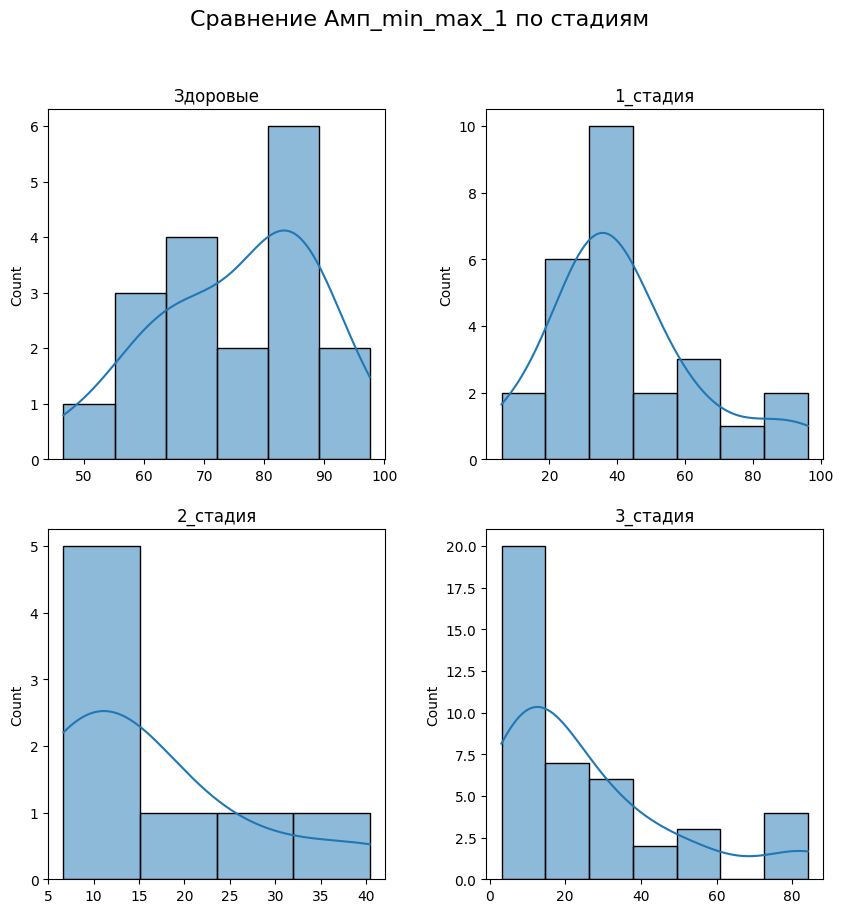

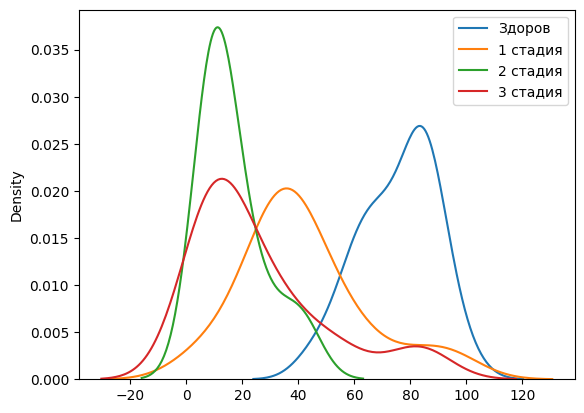


Сравнение здоров/1стадия p_val_Мано-Уитни 1.1855085407661392e-05 p_val_Стьюдент 1.6094394253895602e-07

Сравнение здоров/2стадия p_val_Мано-Уитни 1.2801843465459026e-06 p_val_Стьюдент 4.443215591158151e-09

Сравнение здоров/3стадия p_val_Мано-Уитни 1.1638992368373868e-07 p_val_Стьюдент 3.1575892400524464e-14

Сравнение 1стадия/2стадия p_val_Мано-Уитни 0.002770953664102915 p_val_Стьюдент 0.00026971972457644645

Сравнение 1стадия/3стадия p_val_Мано-Уитни 0.0009239509980126923 p_val_Стьюдент 0.006701904366032644

Сравнение 2стадия/3стадия p_val_Мано-Уитни 0.4740738153770876 p_val_Стьюдент 0.0990782895119284


In [51]:
histo (df_zdorov_usred_po_m, df_1_stage_usred_po_m, df_2_stage_usred_po_m,  df_3_stage_usred_po_m, 'Амп_min_max_1' )

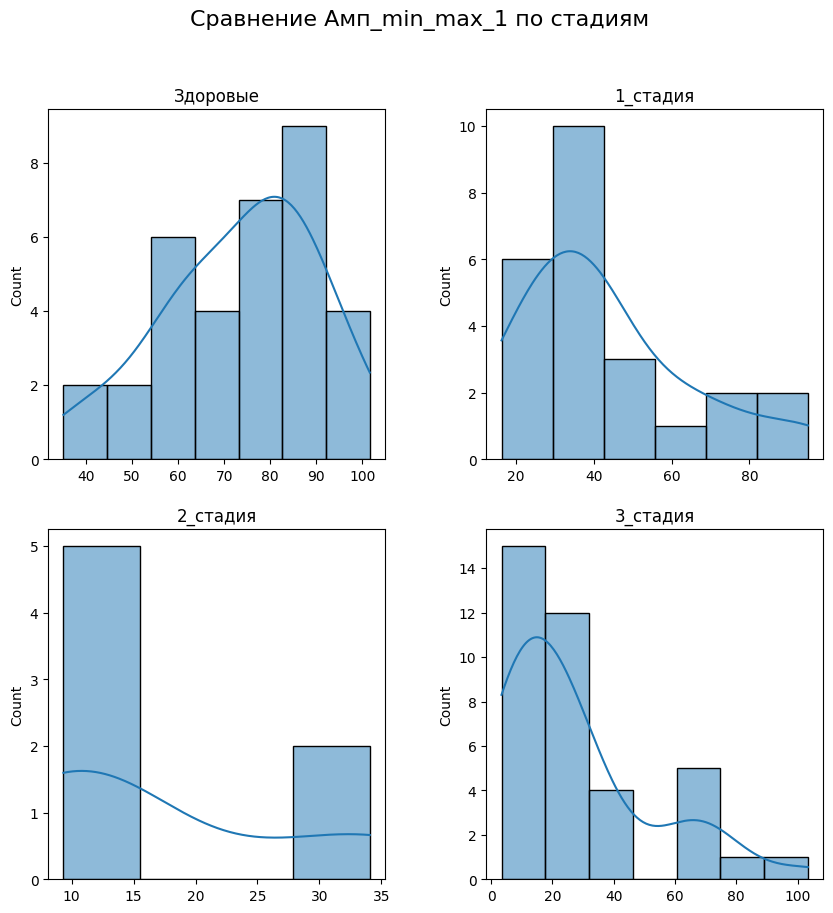

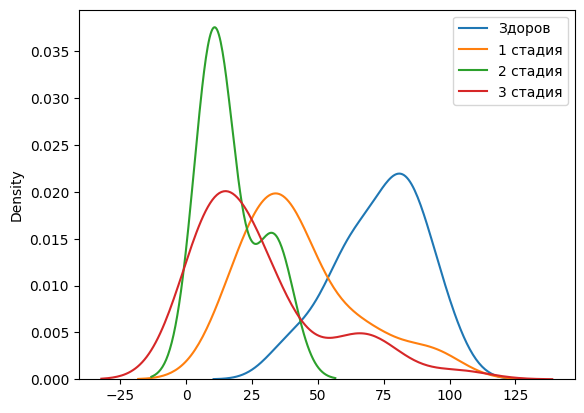


Сравнение здоров/1стадия p_val_Мано-Уитни 4.5109685629985305e-06 p_val_Стьюдент 9.575379143294897e-07

Сравнение здоров/2стадия p_val_Мано-Уитни 8.896029435182196e-08 p_val_Стьюдент 8.360700057655574e-08

Сравнение здоров/3стадия p_val_Мано-Уитни 1.1619824185072121e-09 p_val_Стьюдент 9.137002454479566e-14

Сравнение 1стадия/2стадия p_val_Мано-Уитни 0.0004289666581101509 p_val_Стьюдент 0.00038097011715184547

Сравнение 1стадия/3стадия p_val_Мано-Уитни 0.000739491194069437 p_val_Стьюдент 0.010878607334110202

Сравнение 2стадия/3стадия p_val_Мано-Уитни 0.5494266809638336 p_val_Стьюдент 0.09392248800668297


In [52]:
histo (df_zdorov_usred_po_rukam, df_1_stage_usred_po_rukam, df_2_stage_usred_po_rukam,  df_3_stage_usred_po_rukam, 'Амп_min_max_1' )


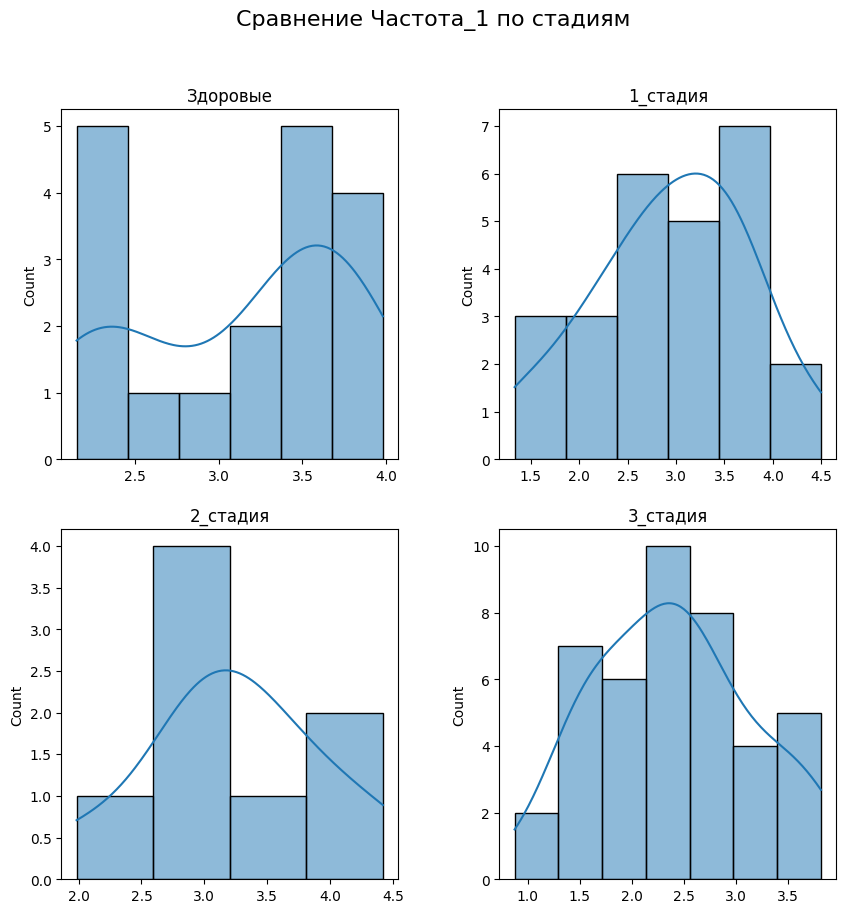

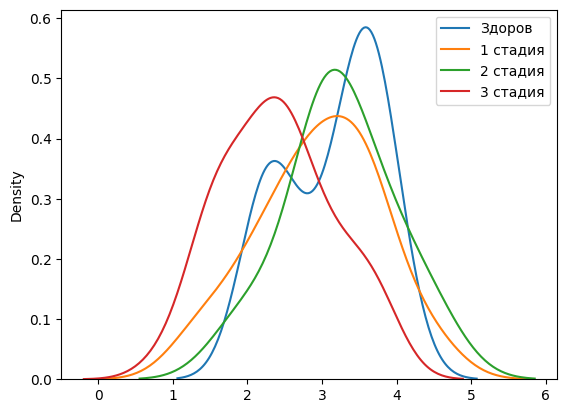


Сравнение здоров/1стадия p_val_Мано-Уитни 0.39677075525990235 p_val_Стьюдент 0.43254764967019554

Сравнение здоров/2стадия p_val_Мано-Уитни 0.9350223232145431 p_val_Стьюдент 0.722873089610678

Сравнение здоров/3стадия p_val_Мано-Уитни 0.0015256113320956104 p_val_Стьюдент 0.0004620355367587052

Сравнение 1стадия/2стадия p_val_Мано-Уитни 0.4361348881076682 p_val_Стьюдент 0.3641933338811626

Сравнение 1стадия/3стадия p_val_Мано-Уитни 0.008044479114014706 p_val_Стьюдент 0.006366258490934433

Сравнение 2стадия/3стадия p_val_Мано-Уитни 0.006045760992730853 p_val_Стьюдент 0.012890059254690625


In [53]:
histo (df_zdorov_usred_po_m, df_1_stage_usred_po_m, df_2_stage_usred_po_m,  df_3_stage_usred_po_m, 'Частота_1' )

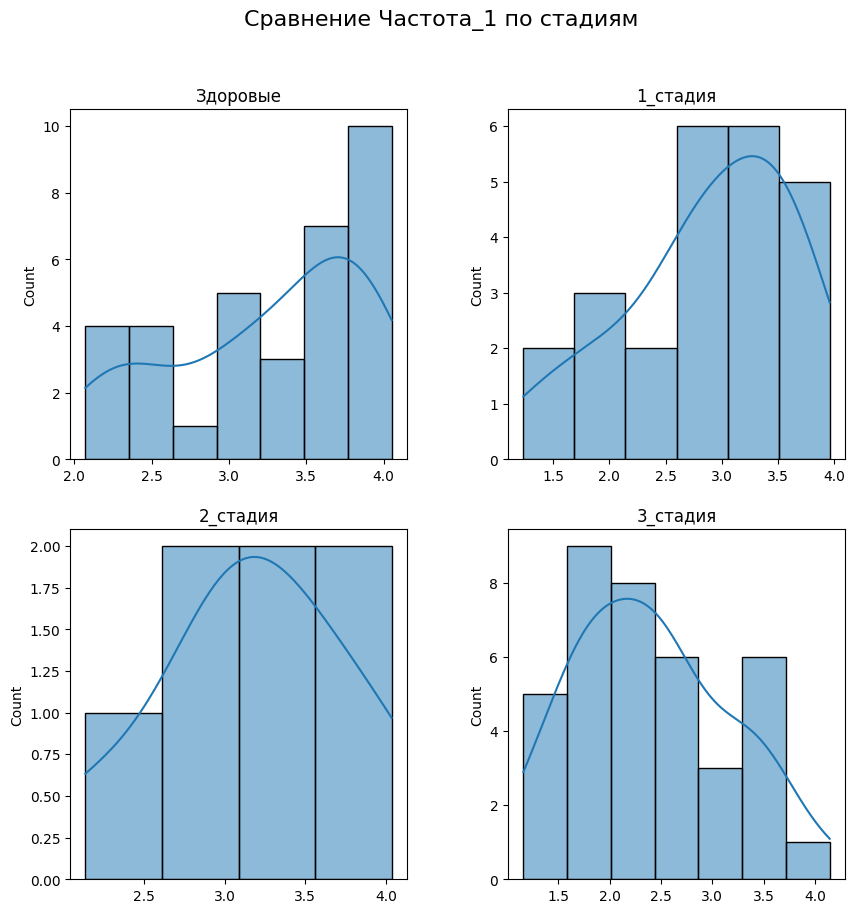

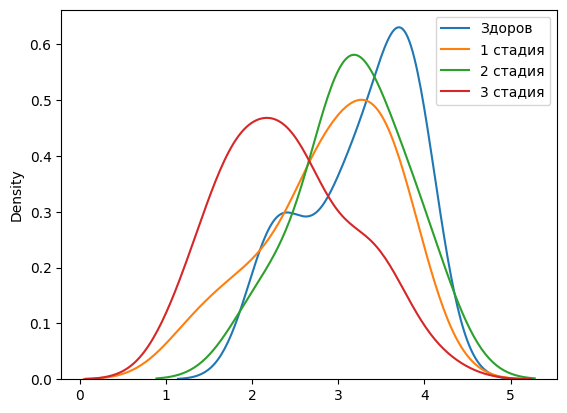


Сравнение здоров/1стадия p_val_Мано-Уитни 0.04755098133924606 p_val_Стьюдент 0.057420574297295184

Сравнение здоров/2стадия p_val_Мано-Уитни 0.6716134817546884 p_val_Стьюдент 0.7568330487780576

Сравнение здоров/3стадия p_val_Мано-Уитни 1.1750449106674048e-05 p_val_Стьюдент 1.7400928358466423e-06

Сравнение 1стадия/2стадия p_val_Мано-Уитни 0.4169525493663425 p_val_Стьюдент 0.32780202173937034

Сравнение 1стадия/3стадия p_val_Мано-Уитни 0.009889987779464024 p_val_Стьюдент 0.016174639480559864

Сравнение 2стадия/3стадия p_val_Мано-Уитни 0.018883102150260404 p_val_Стьюдент 0.015210946007299374


In [54]:
histo (df_zdorov_usred_po_rukam, df_1_stage_usred_po_rukam, df_2_stage_usred_po_rukam,  df_3_stage_usred_po_rukam, 'Частота_1' )

## Задание 2

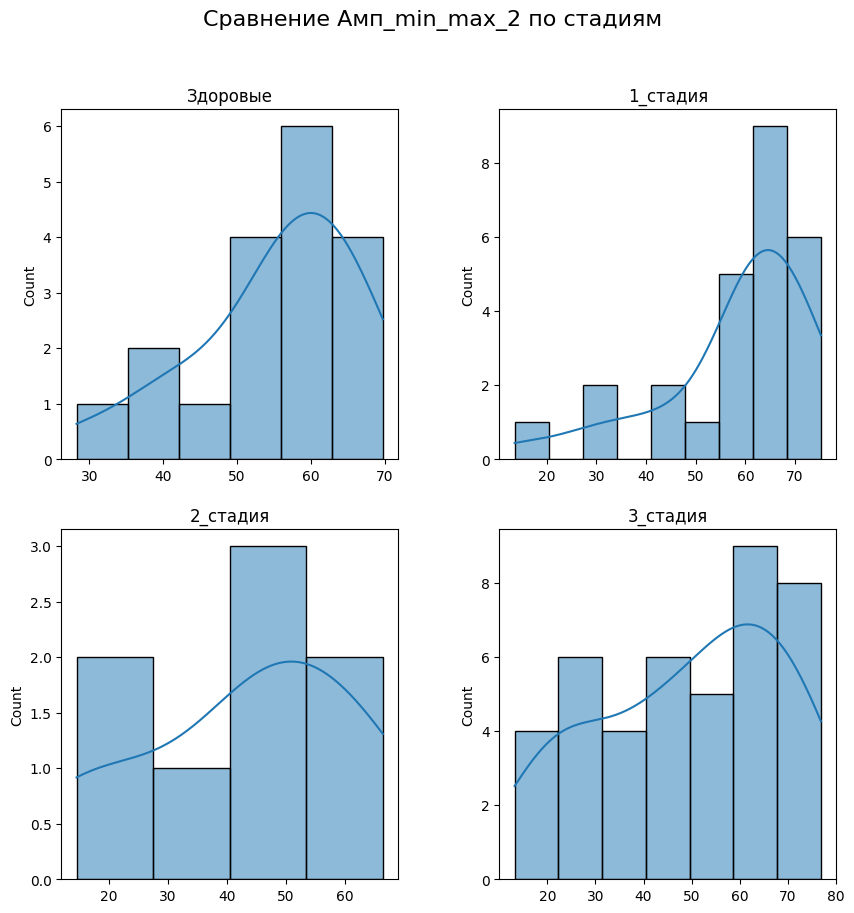

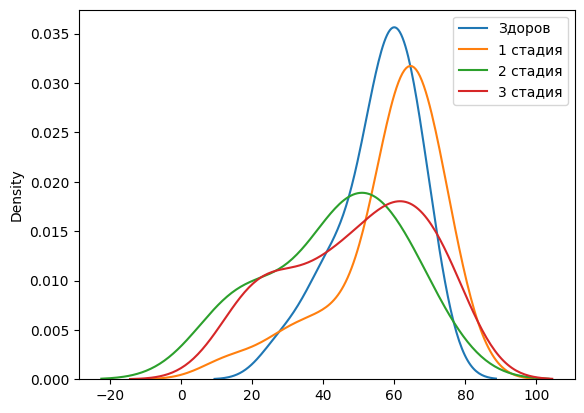


Сравнение здоров/1стадия p_val_Мано-Уитни 0.14209458241876322 p_val_Стьюдент 0.45361374186614056

Сравнение здоров/2стадия p_val_Мано-Уитни 0.09049623145732985 p_val_Стьюдент 0.12256111438731818

Сравнение здоров/3стадия p_val_Мано-Уитни 0.41528865845917895 p_val_Стьюдент 0.1529924020102079

Сравнение 1стадия/2стадия p_val_Мано-Уитни 0.027745116765597034 p_val_Стьюдент 0.06381119895848084

Сравнение 1стадия/3стадия p_val_Мано-Уитни 0.05752637030646211 p_val_Стьюдент 0.04175628832726106

Сравнение 2стадия/3стадия p_val_Мано-Уитни 0.382407834619611 p_val_Стьюдент 0.40613278669333364


In [55]:
histo (df_zdorov_usred_po_m, df_1_stage_usred_po_m, df_2_stage_usred_po_m,  df_3_stage_usred_po_m, 'Амп_min_max_2' )


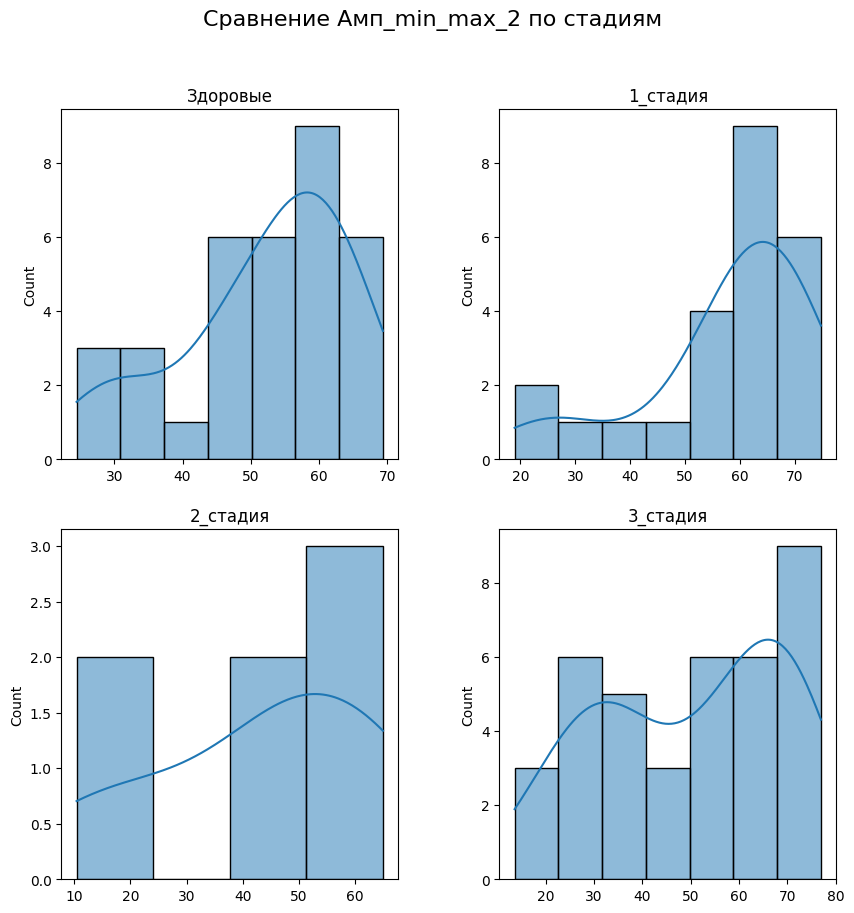

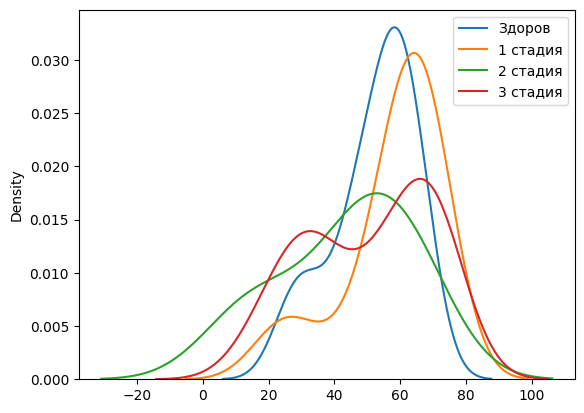


Сравнение здоров/1стадия p_val_Мано-Уитни 0.03506030452936564 p_val_Стьюдент 0.1321619138933567

Сравнение здоров/2стадия p_val_Мано-Уитни 0.28188465941996105 p_val_Стьюдент 0.30850225142551363

Сравнение здоров/3стадия p_val_Мано-Уитни 0.9057214455385272 p_val_Стьюдент 0.6432271748938148

Сравнение 1стадия/2стадия p_val_Мано-Уитни 0.054319043951969424 p_val_Стьюдент 0.11728129953017553

Сравнение 1стадия/3стадия p_val_Мано-Уитни 0.21126903213802517 p_val_Стьюдент 0.0920814065654115

Сравнение 2стадия/3стадия p_val_Мано-Уитни 0.3314661956182092 p_val_Стьюдент 0.4221958053128687


In [56]:
histo (df_zdorov_usred_po_rukam, df_1_stage_usred_po_rukam, df_2_stage_usred_po_rukam,  df_3_stage_usred_po_rukam, 'Амп_min_max_2' )


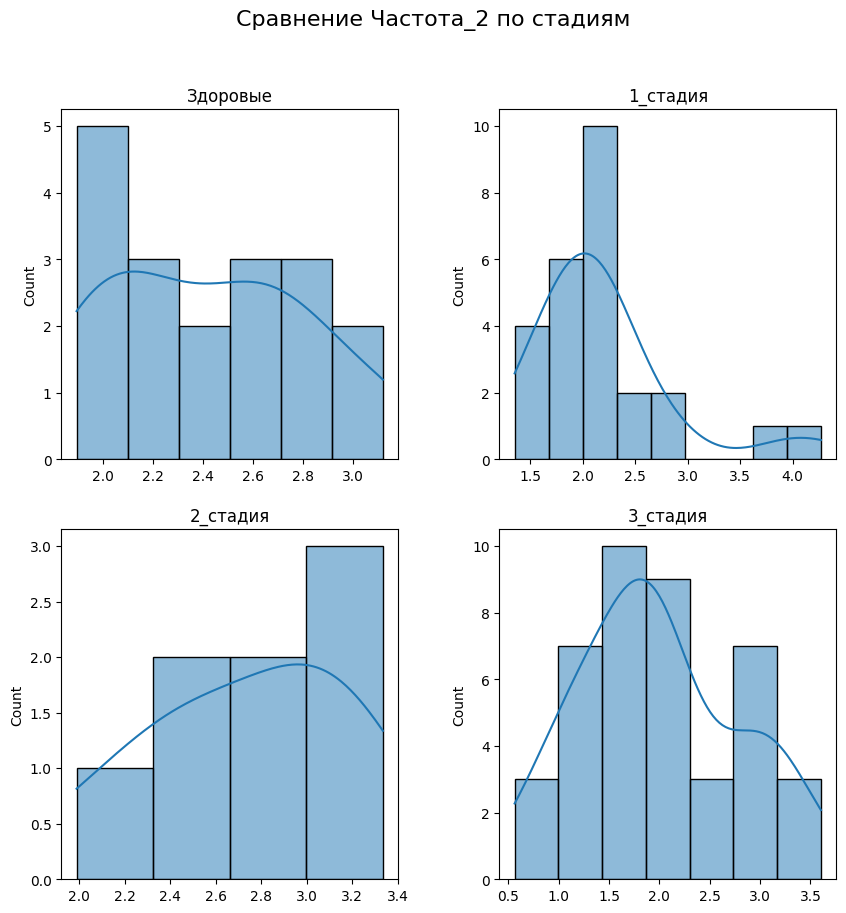

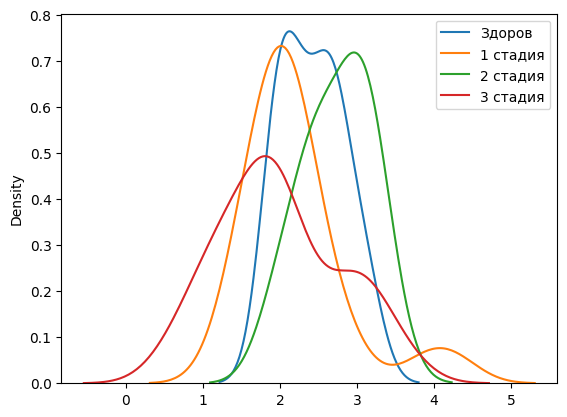


Сравнение здоров/1стадия p_val_Мано-Уитни 0.04368957623078205 p_val_Стьюдент 0.15296703896004066

Сравнение здоров/2стадия p_val_Мано-Уитни 0.09049623145732985 p_val_Стьюдент 0.10918398946248985

Сравнение здоров/3стадия p_val_Мано-Уитни 0.013281574779201315 p_val_Стьюдент 0.006230857727621528

Сравнение 1стадия/2стадия p_val_Мано-Уитни 0.005962259511955253 p_val_Стьюдент 0.015149945073000387

Сравнение 1стадия/3стадия p_val_Мано-Уитни 0.2232934804624025 p_val_Стьюдент 0.2609732430727561

Сравнение 2стадия/3стадия p_val_Мано-Уитни 0.007271430890388359 p_val_Стьюдент 0.001576912524297937


In [57]:
histo (df_zdorov_usred_po_m, df_1_stage_usred_po_m, df_2_stage_usred_po_m,  df_3_stage_usred_po_m, 'Частота_2' )

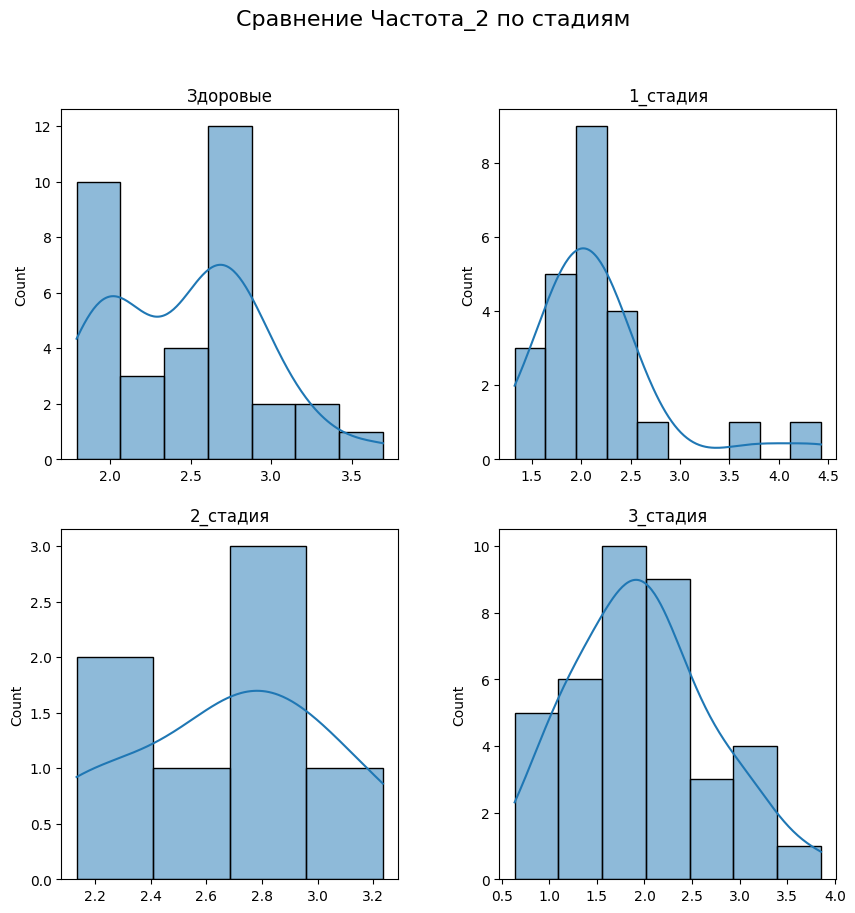

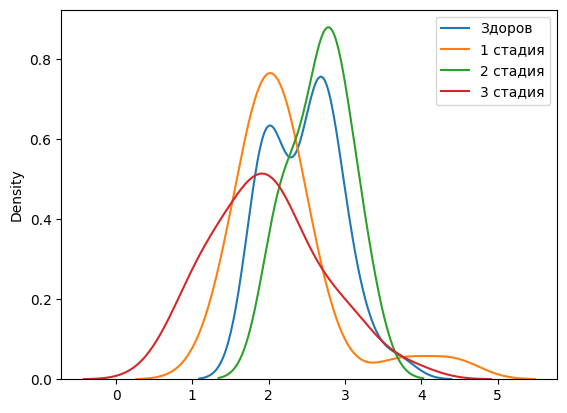


Сравнение здоров/1стадия p_val_Мано-Уитни 0.012337038506675708 p_val_Стьюдент 0.08692231530560339

Сравнение здоров/2стадия p_val_Мано-Уитни 0.15353150128503146 p_val_Стьюдент 0.2505683988034788

Сравнение здоров/3стадия p_val_Мано-Уитни 0.0011831282174094636 p_val_Стьюдент 0.0010354035067452114

Сравнение 1стадия/2стадия p_val_Мано-Уитни 0.005466282574180238 p_val_Стьюдент 0.027303353672847433

Сравнение 1стадия/3стадия p_val_Мано-Уитни 0.25659792174082585 p_val_Стьюдент 0.23903962026272088

Сравнение 2стадия/3стадия p_val_Мано-Уитни 0.008430744902667762 p_val_Стьюдент 0.002092808310957403


In [58]:
histo (df_zdorov_usred_po_rukam, df_1_stage_usred_po_rukam, df_2_stage_usred_po_rukam,  df_3_stage_usred_po_rukam, 'Частота_2' )


## 3 Задание

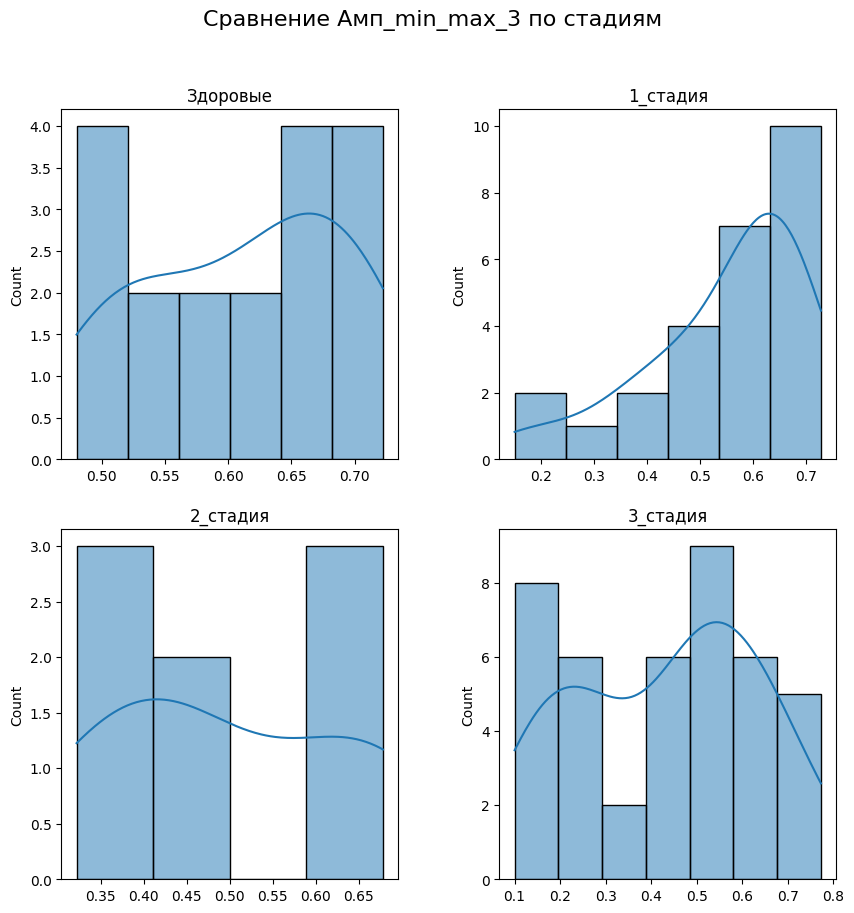

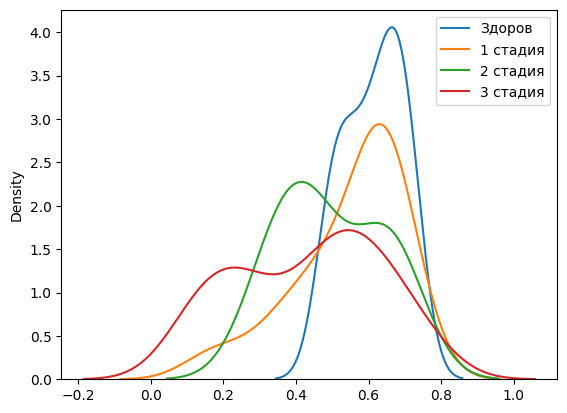


Сравнение здоров/1стадия p_val_Мано-Уитни 0.19327830114962885 p_val_Стьюдент 0.06919792423282599

Сравнение здоров/2стадия p_val_Мано-Уитни 0.03518330639612104 p_val_Стьюдент 0.058848460983969564

Сравнение здоров/3стадия p_val_Мано-Уитни 0.0007262524060905059 p_val_Стьюдент 5.455077147074369e-06

Сравнение 1стадия/2стадия p_val_Мано-Уитни 0.4127681094572411 p_val_Стьюдент 0.409035435113587

Сравнение 1стадия/3стадия p_val_Мано-Уитни 0.011813617433066054 p_val_Стьюдент 0.00819963615920607

Сравнение 2стадия/3стадия p_val_Мано-Уитни 0.39691330992580914 p_val_Стьюдент 0.27109286649625175


In [59]:
histo (df_zdorov_usred_po_m, df_1_stage_usred_po_m, df_2_stage_usred_po_m,  df_3_stage_usred_po_m, 'Амп_min_max_3' )


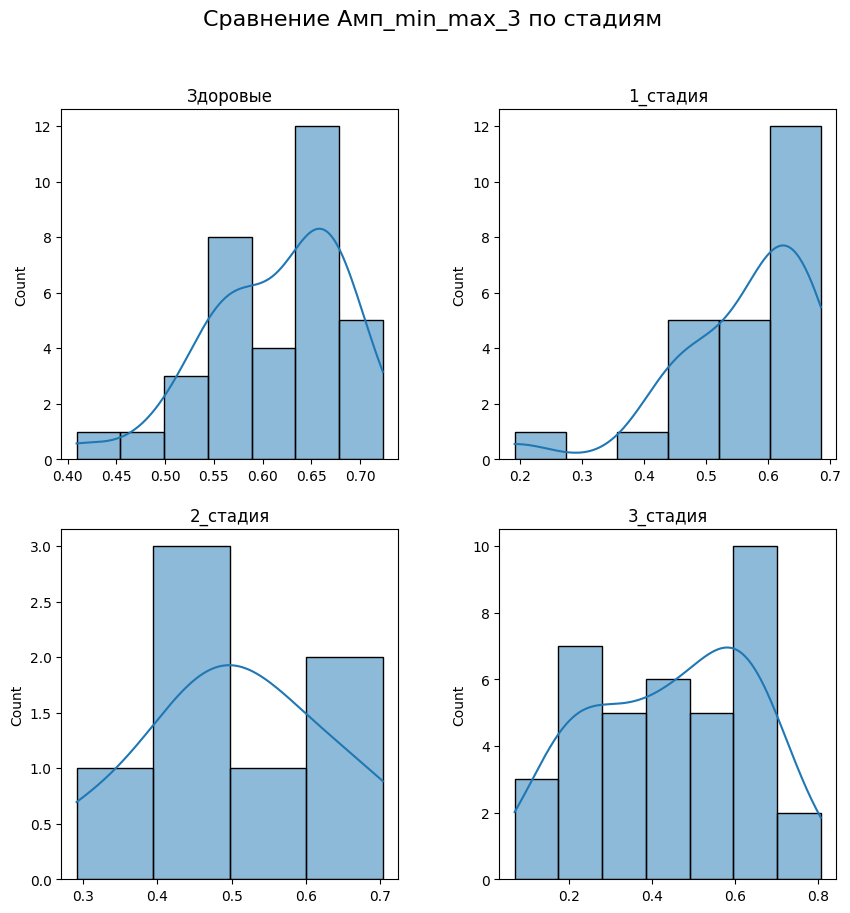

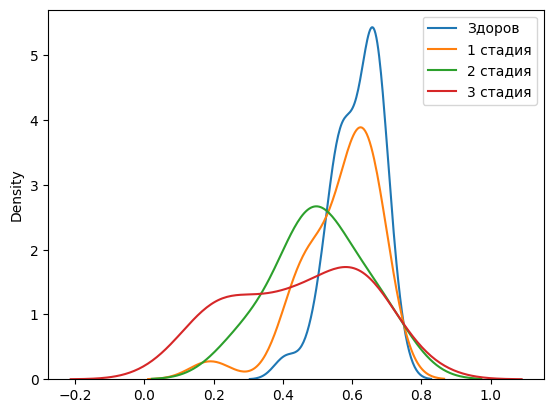


Сравнение здоров/1стадия p_val_Мано-Уитни 0.08966256361085306 p_val_Стьюдент 0.059158334903947805

Сравнение здоров/2стадия p_val_Мано-Уитни 0.025411419121303586 p_val_Стьюдент 0.07765181657683354

Сравнение здоров/3стадия p_val_Мано-Уитни 0.00012842393927682305 p_val_Стьюдент 1.0735803974397391e-05

Сравнение 1стадия/2стадия p_val_Мано-Уитни 0.3651456984493692 p_val_Стьюдент 0.33427263971665155

Сравнение 1стадия/3стадия p_val_Мано-Уитни 0.02371521290803562 p_val_Стьюдент 0.004564008159211873

Сравнение 2стадия/3стадия p_val_Мано-Уитни 0.5090017501248358 p_val_Стьюдент 0.3412044468927118


In [60]:
histo (df_zdorov_usred_po_rukam, df_1_stage_usred_po_rukam, df_2_stage_usred_po_rukam,  df_3_stage_usred_po_rukam, 'Амп_min_max_3' )


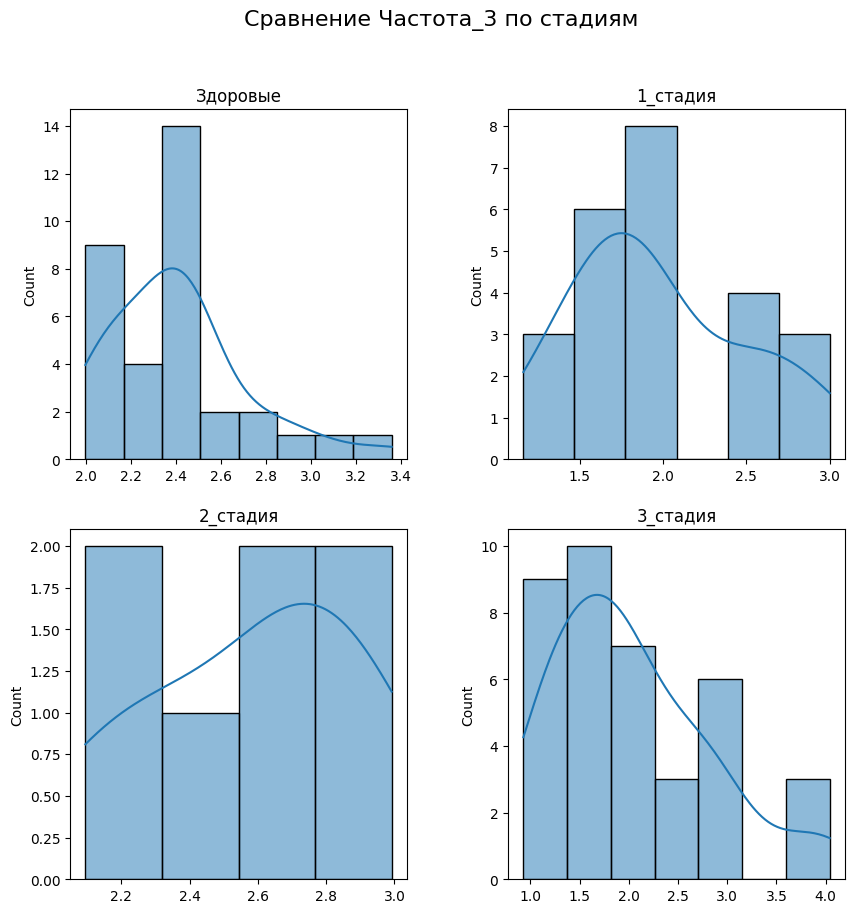

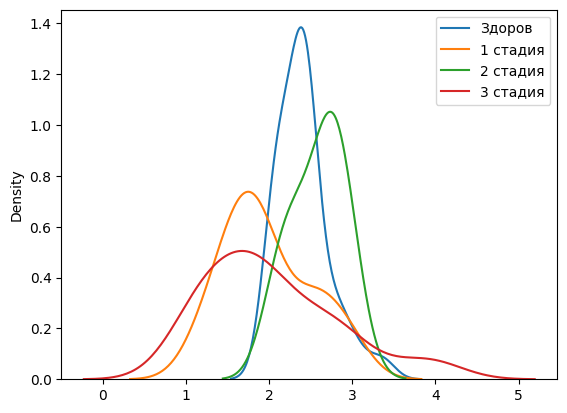


Сравнение здоров/1стадия p_val_Мано-Уитни 0.001082685735404316 p_val_Стьюдент 0.0009923635789841811

Сравнение здоров/2стадия p_val_Мано-Уитни 0.12736487586662518 p_val_Стьюдент 0.21029548900096776

Сравнение здоров/3стадия p_val_Мано-Уитни 0.001815646319707838 p_val_Стьюдент 0.01021820038579811

Сравнение 1стадия/2стадия p_val_Мано-Уитни 0.007692497837102954 p_val_Стьюдент 0.001613908538778374

Сравнение 1стадия/3стадия p_val_Мано-Уитни 0.8793886590272973 p_val_Стьюдент 0.7389556374745073

Сравнение 2стадия/3стадия p_val_Мано-Уитни 0.032353642450069 p_val_Стьюдент 0.004880312717830617


In [61]:
histo (df_zdorov_usred_po_rukam, df_1_stage_usred_po_rukam, df_2_stage_usred_po_rukam,  df_3_stage_usred_po_rukam, 'Частота_3' )


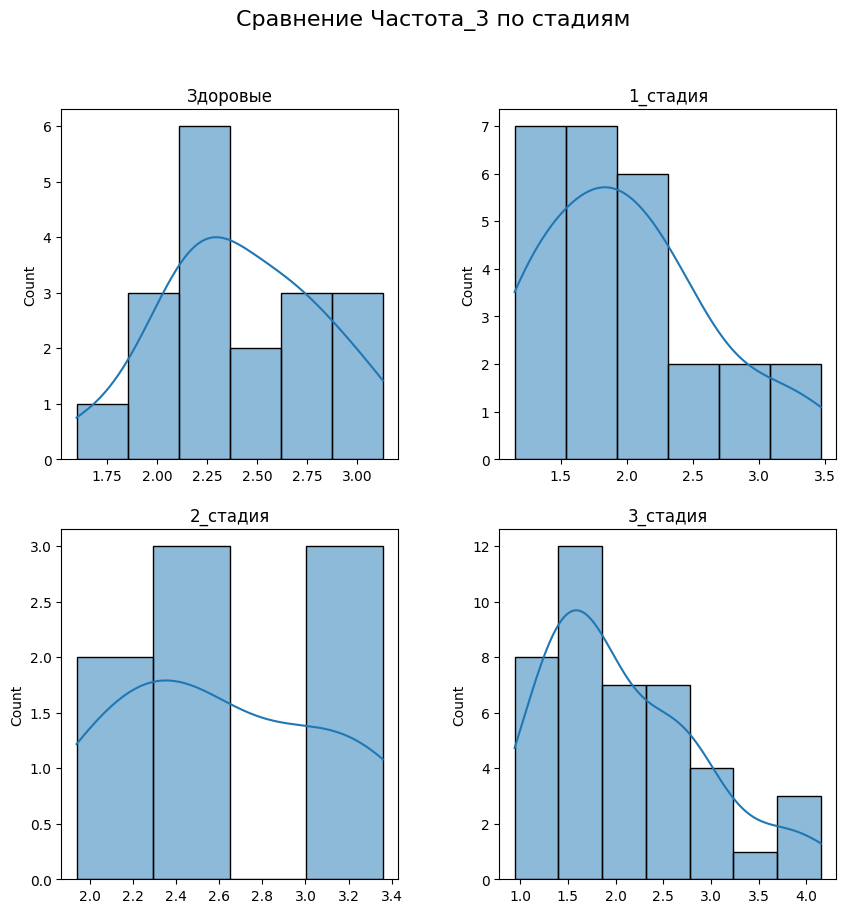

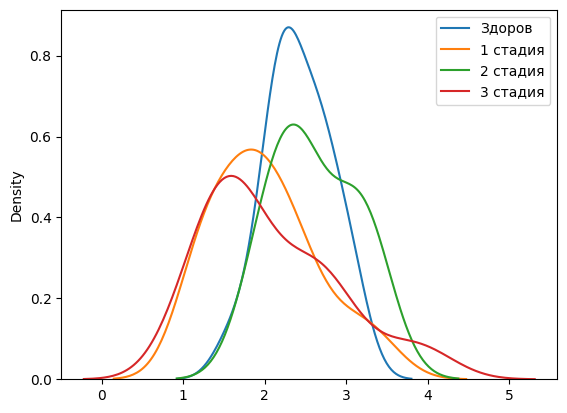


Сравнение здоров/1стадия p_val_Мано-Уитни 0.00959902090605929 p_val_Стьюдент 0.010991703271218959

Сравнение здоров/2стадия p_val_Мано-Уитни 0.36701092957385867 p_val_Стьюдент 0.35658714750112697

Сравнение здоров/3стадия p_val_Мано-Уитни 0.025472442692837705 p_val_Стьюдент 0.0356717509542932

Сравнение 1стадия/2стадия p_val_Мано-Уитни 0.017327961285299502 p_val_Стьюдент 0.014342397601262222

Сравнение 1стадия/3стадия p_val_Мано-Уитни 0.8846094451762859 p_val_Стьюдент 0.6585192620543102

Сравнение 2стадия/3стадия p_val_Мано-Уитни 0.03857666904802416 p_val_Стьюдент 0.028733081598593512


In [62]:
histo (df_zdorov_usred_po_m, df_1_stage_usred_po_m, df_2_stage_usred_po_m,  df_3_stage_usred_po_m, 'Частота_3' )


# Классификаторы

In [62]:
def plot_confusion_matrix(y_true, y_pred, classes, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """

    # Compute confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred)
    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax, cm

In [63]:
def train_test_splitting(df, test_size = 0.2, random_state = 10):

    nums =df['Индекс пациента'].unique()
    df  = df.groupby(['Индекс пациента', 'Номер эксперимента']).agg({'Индекс пациента':'max', 'Таргет':'max','Амп_min_max_1': 'mean', 'Амплитуда_median_1': 'mean', 'Частота_1': 'mean',
        'Амп_min_max_2': 'mean', 'Амплитуда_median_2': 'mean', 'Частота_2': 'mean',
       'Амп_min_max_3': 'mean', 'Амплитуда_median_3': 'mean' ,'Частота_3': 'mean'})
    n_test_examples = int(len(df)*test_size)


    seq_test = random.sample(set(nums),len(nums))
    df_test = pd.DataFrame(columns= ['Индекс пациента','Таргет', 
       'Амп_min_max_1', 'Амплитуда_median_1', 'Частота_1', 'Амп_min_max_2',
       'Амплитуда_median_2', 'Частота_2', 'Амп_min_max_3',
       'Амплитуда_median_3', 'Частота_3'])
    df_train= pd.DataFrame(columns= ['Индекс пациента','Таргет', 
       'Амп_min_max_1', 'Амплитуда_median_1', 'Частота_1', 'Амп_min_max_2',
       'Амплитуда_median_2', 'Частота_2', 'Амп_min_max_3',
       'Амплитуда_median_3', 'Частота_3'])
    
    q =[]
  
    for i in seq_test:
        new_rows = df.loc[i]
        df_test = pd.concat([df_test,new_rows])
        q.append(i)
        if len(df_test)>n_test_examples:
            break
    numbers = [num for num in nums if num not in q]
    
    seq_train = random.sample(set(numbers), len(numbers))


    n_train_examples = len(df) - len(df_test)
   
    for i in seq_train:
        new_rows = df.loc[i]
        df_train = pd.concat([df_train,new_rows])
        if len(df_train)>n_train_examples:
        
            break
    print('Распределение элементов в тест выборке \nКласс 0: ', len(df_test[df_test['Таргет']== 0 ]),'\nКласс1: ', len(df_test) - len(df_test[df_test['Таргет']== 0 ]))

    print('Распределение элементов в train выборке \nКласс0: ', len(df_train[df_train['Таргет']== 0 ]),'\nКласс1: ', len(df_train) - len(df_train[df_train['Таргет']== 0 ]))

    return np.array(df_train[['Амп_min_max_1', 'Амплитуда_median_1', 'Частота_1', 'Амп_min_max_2',
       'Амплитуда_median_2', 'Частота_2', 'Амп_min_max_3',
       'Амплитуда_median_3', 'Частота_3']]), np.array(df_test[['Амп_min_max_1', 'Амплитуда_median_1', 'Частота_1', 'Амп_min_max_2',
       'Амплитуда_median_2', 'Частота_2', 'Амп_min_max_3',
       'Амплитуда_median_3', 'Частота_3']]), np.array(df_train['Таргет']).astype(int), np.array(df_test['Таргет']).astype(int)


## Больные/здоровые

In [81]:
X_train , X_test, Y_train, Y_test = train_test_splitting (df_zdorov_bolen)

Распределение элементов в тест выборке 
Класс 0:  10 
Класс1:  11
Распределение элементов в train выборке 
Класс0:  25 
Класс1:  56


C:\Users\Asus\AppData\Local\Temp\ipykernel_14516\2242156598.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  seq_test = random.sample(set(nums),len(nums))
C:\Users\Asus\AppData\Local\Temp\ipykernel_14516\2242156598.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_test = pd.concat([df_test,new_rows])
C:\Users\Asus\AppData\Local\Temp\ipykernel_14516\2242156598.py:30: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  seq_train = random.sample(set(numbers), len(numbers))
C:\Users\Asus\AppData\Local\Temp\ipykernel_14516\2242156598.py:37: FutureWarning: The behavior of DataFrame concatenation with empty 

[[10  0]
 [ 0 11]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        11

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21

Точность 1.0


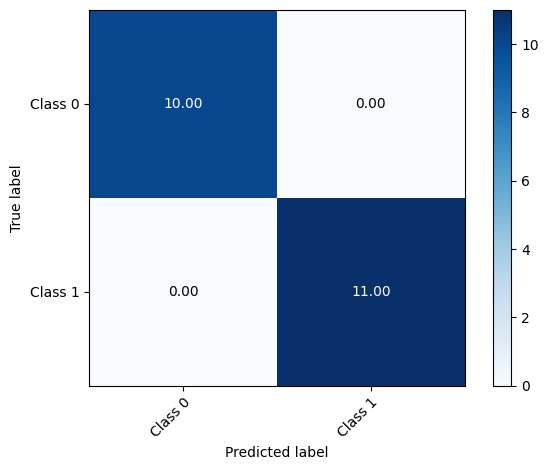

In [82]:
les = RandomForestClassifier(random_state=17)

param_grid_les = {'n_estimators': list(range(1, 10)), 'max_depth': list(range(1,10)), 'max_features': list(range(1,5))}
grid_search_les = GridSearchCV(les, param_grid_les, cv=5)
grid_search_les.fit(X_train, Y_train)

y_pred_les = grid_search_les.predict(X_test)
accuracy = accuracy_score(Y_test, y_pred_les)
conf_matrix = plot_confusion_matrix(Y_test, y_pred_les, classes=np.array(["Class 0", "Class 1"]))
classification_rep = classification_report(Y_test, y_pred_les)
print(classification_rep)
print( 'Точность', accuracy)

[[9 1]
 [2 9]]
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        10
           1       0.90      0.82      0.86        11

    accuracy                           0.86        21
   macro avg       0.86      0.86      0.86        21
weighted avg       0.86      0.86      0.86        21

Точность 0.8571428571428571


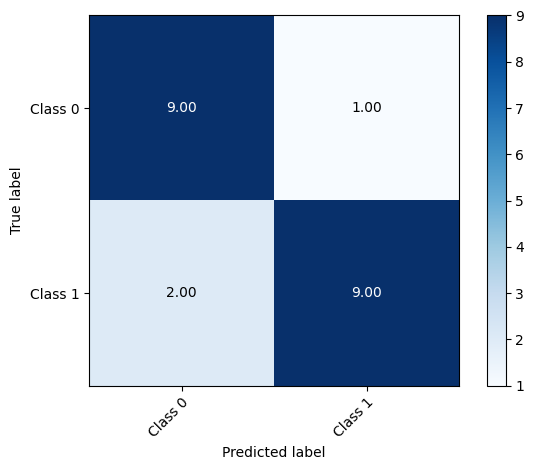

In [84]:
neigh = KNeighborsClassifier(n_neighbors=5)
param_grid_neigh = {'n_neighbors': list(range(3, 10))}
grid_search_neigh = GridSearchCV(neigh, param_grid_neigh, cv=5)
grid_search_neigh.fit(X_train, Y_train)

y_pred = grid_search_neigh.predict(X_test)

conf_matrix = plot_confusion_matrix(Y_test, y_pred, classes=np.array(["Class 0", "Class 1"]))

classification_rep2 = classification_report(Y_test, y_pred)
print(classification_rep2)
print( 'Точность', accuracy_score(Y_test, y_pred))

## Здоровые/1 Стадия

In [92]:
X_train , X_test, Y_train, Y_test = train_test_splitting (df_zdorov_1stage)


Распределение элементов в тест выборке 
Класс 0:  6 
Класс1:  9
Распределение элементов в train выборке 
Класс0:  29 
Класс1:  9


C:\Users\Asus\AppData\Local\Temp\ipykernel_14516\2242156598.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  seq_test = random.sample(set(nums),len(nums))
C:\Users\Asus\AppData\Local\Temp\ipykernel_14516\2242156598.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_test = pd.concat([df_test,new_rows])
C:\Users\Asus\AppData\Local\Temp\ipykernel_14516\2242156598.py:30: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  seq_train = random.sample(set(numbers), len(numbers))
C:\Users\Asus\AppData\Local\Temp\ipykernel_14516\2242156598.py:37: FutureWarning: The behavior of DataFrame concatenation with empty 

[[6 0]
 [5 4]]
              precision    recall  f1-score   support

           0       0.55      1.00      0.71         6
           1       1.00      0.44      0.62         9

    accuracy                           0.67        15
   macro avg       0.77      0.72      0.66        15
weighted avg       0.82      0.67      0.65        15

Точность 0.6666666666666666


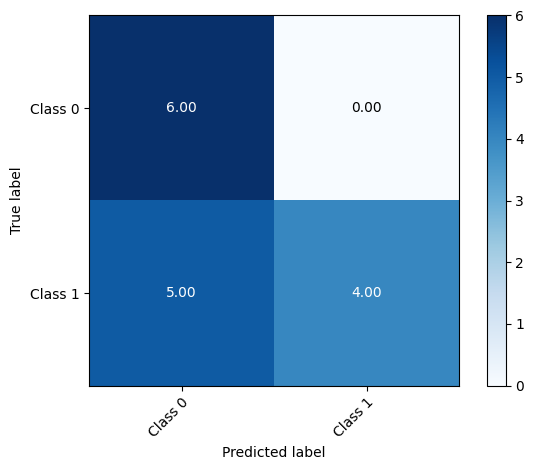

In [93]:
les = RandomForestClassifier(random_state=17)

param_grid_les = {'n_estimators': list(range(1, 10)), 'max_depth': list(range(1,10)), 'max_features': list(range(1,5))}
grid_search_les = GridSearchCV(les, param_grid_les, cv=5)
grid_search_les.fit(X_train, Y_train)

y_pred_les = grid_search_les.predict(X_test)
accuracy = accuracy_score(Y_test, y_pred_les)
conf_matrix = plot_confusion_matrix(Y_test, y_pred_les, classes=np.array(["Class 0", "Class 1"]))
classification_rep = classification_report(Y_test, y_pred_les)
print(classification_rep)
print( 'Точность', accuracy)

[[6 0]
 [4 5]]
              precision    recall  f1-score   support

           0       0.60      1.00      0.75         6
           1       1.00      0.56      0.71         9

    accuracy                           0.73        15
   macro avg       0.80      0.78      0.73        15
weighted avg       0.84      0.73      0.73        15

Точность 0.7333333333333333


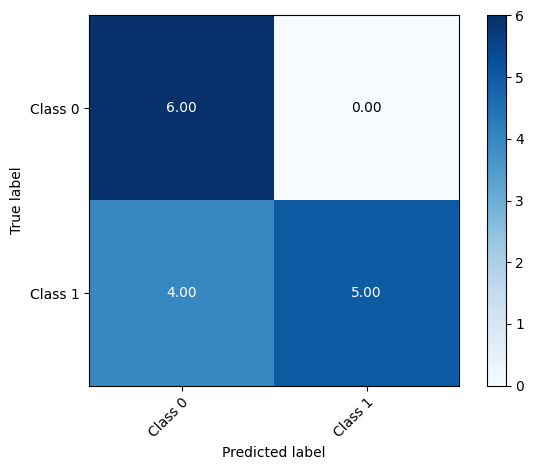

In [94]:
neigh = KNeighborsClassifier(n_neighbors=5)
param_grid_neigh = {'n_neighbors': list(range(3, 10))}
grid_search_neigh = GridSearchCV(neigh, param_grid_neigh, cv=5)
grid_search_neigh.fit(X_train, Y_train)

y_pred = grid_search_neigh.predict(X_test)

conf_matrix = plot_confusion_matrix(Y_test, y_pred, classes=np.array(["Class 0", "Class 1"]))

classification_rep2 = classification_report(Y_test, y_pred)
print(classification_rep2)
print( 'Точность', accuracy_score(Y_test, y_pred))

## Здоров/ 23СТадия

In [95]:
X_train , X_test, Y_train, Y_test = train_test_splitting (df_zdorov_23stage)

Распределение элементов в тест выборке 
Класс 0:  7 
Класс1:  10
Распределение элементов в train выборке 
Класс0:  28 
Класс1:  39


C:\Users\Asus\AppData\Local\Temp\ipykernel_14516\2242156598.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  seq_test = random.sample(set(nums),len(nums))
C:\Users\Asus\AppData\Local\Temp\ipykernel_14516\2242156598.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_test = pd.concat([df_test,new_rows])
C:\Users\Asus\AppData\Local\Temp\ipykernel_14516\2242156598.py:30: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  seq_train = random.sample(set(numbers), len(numbers))
C:\Users\Asus\AppData\Local\Temp\ipykernel_14516\2242156598.py:37: FutureWarning: The behavior of DataFrame concatenation with empty 

[[6 1]
 [3 7]]
              precision    recall  f1-score   support

           0       0.67      0.86      0.75         7
           2       0.88      0.70      0.78        10

    accuracy                           0.76        17
   macro avg       0.77      0.78      0.76        17
weighted avg       0.79      0.76      0.77        17

Точность 0.7647058823529411





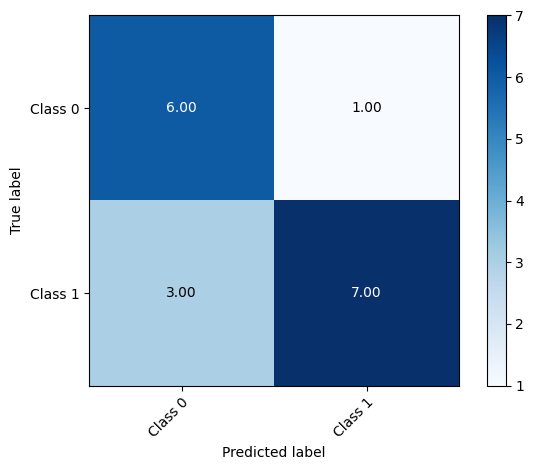

In [96]:
les = RandomForestClassifier(random_state=17)

param_grid_les = {'n_estimators': list(range(1, 10)), 'max_depth': list(range(1,10)), 'max_features': list(range(1,5))}
grid_search_les = GridSearchCV(les, param_grid_les, cv=5)
grid_search_les.fit(X_train, Y_train)

y_pred_les = grid_search_les.predict(X_test)
accuracy = accuracy_score(Y_test, y_pred_les)
conf_matrix = plot_confusion_matrix(Y_test, y_pred_les, classes=np.array(["Class 0", "Class 1"]))
classification_rep = classification_report(Y_test, y_pred_les)
print(classification_rep)
print( 'Точность', accuracy)
print('\n\n')


[[5 2]
 [2 8]]
              precision    recall  f1-score   support

           0       0.71      0.71      0.71         7
           2       0.80      0.80      0.80        10

    accuracy                           0.76        17
   macro avg       0.76      0.76      0.76        17
weighted avg       0.76      0.76      0.76        17

Точность 0.7647058823529411


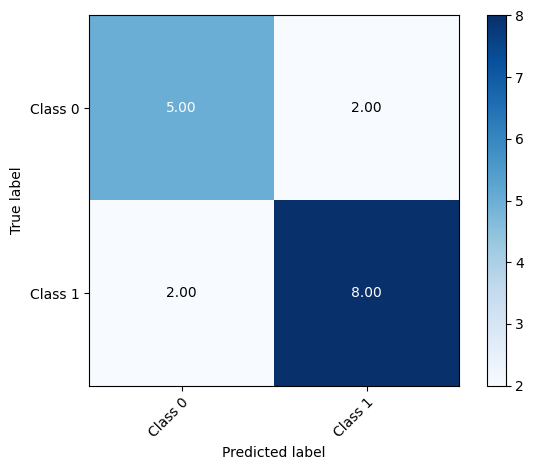

In [97]:
neigh = KNeighborsClassifier(n_neighbors=5)
param_grid_neigh = {'n_neighbors': list(range(3, 10))}
grid_search_neigh = GridSearchCV(neigh, param_grid_neigh, cv=5)
grid_search_neigh.fit(X_train, Y_train)

y_pred = grid_search_neigh.predict(X_test)

conf_matrix = plot_confusion_matrix(Y_test, y_pred, classes=np.array(["Class 0", "Class 1"]))

classification_rep2 = classification_report(Y_test, y_pred)
print(classification_rep2)
print( 'Точность', accuracy_score(Y_test, y_pred))

## 1Стадия/23 СТадия

In [99]:
X_train , X_test, Y_train, Y_test = train_test_splitting (df_1stage_23stage)

Распределение элементов в тест выборке 
Класс 0:  0 
Класс1:  12
Распределение элементов в train выборке 
Класс0:  0 
Класс1:  47


C:\Users\Asus\AppData\Local\Temp\ipykernel_12496\2242156598.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  seq_test = random.sample(set(nums),len(nums))
C:\Users\Asus\AppData\Local\Temp\ipykernel_12496\2242156598.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_test = pd.concat([df_test,new_rows])
C:\Users\Asus\AppData\Local\Temp\ipykernel_12496\2242156598.py:30: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  seq_train = random.sample(set(numbers), len(numbers))
C:\Users\Asus\AppData\Local\Temp\ipykernel_12496\2242156598.py:37: FutureWarning: The behavior of DataFrame concatenation with empty 

[[0 6]
 [0 8]]
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         6
           2       0.57      1.00      0.73         8

    accuracy                           0.57        14
   macro avg       0.29      0.50      0.36        14
weighted avg       0.33      0.57      0.42        14

Точность 0.5714285714285714


c:\Users\Asus\anaconda3\envs\polguev\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Asus\anaconda3\envs\polguev\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Asus\anaconda3\envs\polguev\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


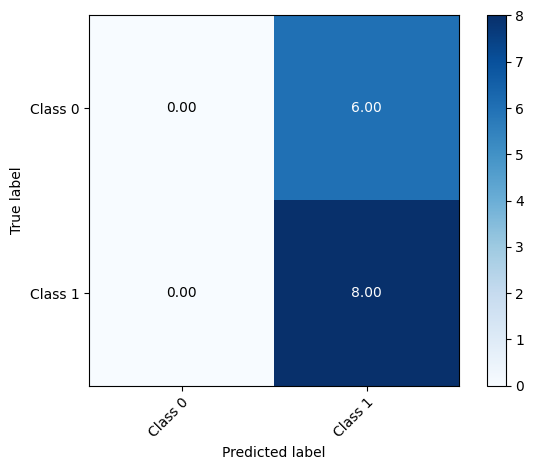

In [140]:
les = RandomForestClassifier(random_state=17)

param_grid_les = {'n_estimators': list(range(1, 10)), 'max_depth': list(range(1,10)), 'max_features': list(range(1,5))}
grid_search_les = GridSearchCV(les, param_grid_les, cv=5)
grid_search_les.fit(X_train, Y_train)

y_pred_les = grid_search_les.predict(X_test)
accuracy = accuracy_score(Y_test, y_pred_les)
conf_matrix = plot_confusion_matrix(Y_test, y_pred_les, classes=np.array(["Class 0", "Class 1"]))
classification_rep = classification_report(Y_test, y_pred_les)
print(classification_rep)
print( 'Точность', accuracy)

[[1 5]
 [4 4]]
              precision    recall  f1-score   support

           1       0.20      0.17      0.18         6
           2       0.44      0.50      0.47         8

    accuracy                           0.36        14
   macro avg       0.32      0.33      0.33        14
weighted avg       0.34      0.36      0.35        14

Точность 0.35714285714285715


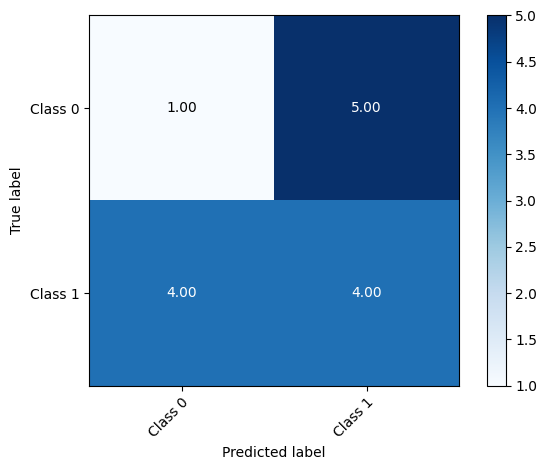

In [141]:
neigh = KNeighborsClassifier(n_neighbors=5)
param_grid_neigh = {'n_neighbors': list(range(3, 10))}
grid_search_neigh = GridSearchCV(neigh, param_grid_neigh, cv=5)
grid_search_neigh.fit(X_train, Y_train)

y_pred = grid_search_neigh.predict(X_test)

conf_matrix = plot_confusion_matrix(Y_test, y_pred, classes=np.array(["Class 0", "Class 1"]))

classification_rep2 = classification_report(Y_test, y_pred)
print(classification_rep2)
print( 'Точность', accuracy_score(Y_test, y_pred))

In [176]:
df_zdorov_usred_po_rukam = df_zdorov.groupby(['Индекс пациента', 'Номер эксперимента']).agg({ 'Таргет':'max','Амп_min_max_1': 'mean', 'Амплитуда_median_1': 'mean', 'Частота_1': 'mean',
    'Амп_min_max_2': 'mean', 'Амплитуда_median_2': 'mean', 'Частота_2': 'mean',
    'Амп_min_max_3': 'mean', 'Амплитуда_median_3': 'mean' ,'Частота_3': 'mean'})
df_zdorov_usred_po_rukam = df_zdorov_usred_po_rukam[df_zdorov_usred_po_rukam['Частота_1']>1.5]

df_1_stage_usred_po_rukam = df_1stage.groupby(['Индекс пациента', 'Номер эксперимента']).agg({ 'Таргет':'max','Амп_min_max_1': 'mean', 'Амплитуда_median_1': 'mean', 'Частота_1': 'mean',
    'Амп_min_max_2': 'mean', 'Амплитуда_median_2': 'mean', 'Частота_2': 'mean',
    'Амп_min_max_3': 'mean', 'Амплитуда_median_3': 'mean' ,'Частота_3': 'mean'})

df_2_stage_usred_po_rukam = df_2stage.groupby(['Индекс пациента', 'Номер эксперимента']).agg({ 'Таргет':'max','Амп_min_max_1': 'mean', 'Амплитуда_median_1': 'mean', 'Частота_1': 'mean',
    'Амп_min_max_2': 'mean', 'Амплитуда_median_2': 'mean', 'Частота_2': 'mean',
    'Амп_min_max_3': 'mean', 'Амплитуда_median_3': 'mean' ,'Частота_3': 'mean'})

df_3_stage_usred_po_rukam = df_3stage.groupby(['Индекс пациента', 'Номер эксперимента']).agg({ 'Таргет':'max','Амп_min_max_1': 'mean', 'Амплитуда_median_1': 'mean', 'Частота_1': 'mean',
    'Амп_min_max_2': 'mean', 'Амплитуда_median_2': 'mean', 'Частота_2': 'mean',
    'Амп_min_max_3': 'mean', 'Амплитуда_median_3': 'mean' ,'Частота_3': 'mean'})

In [177]:
df_zdorov_usred_po_m = df_zdorov.groupby(['Индекс пациента', 'Рука']).agg({ 'Таргет':'max','Амп_min_max_1': 'mean', 'Амплитуда_median_1': 'mean', 'Частота_1': 'mean',
    'Амп_min_max_2': 'mean', 'Амплитуда_median_2': 'mean', 'Частота_2': 'mean',
    'Амп_min_max_3': 'mean', 'Амплитуда_median_3': 'mean' ,'Частота_3': 'mean'})

df_1_stage_usred_po_m = df_1stage.groupby(['Индекс пациента', 'Рука']).agg({ 'Таргет':'max','Амп_min_max_1': 'mean', 'Амплитуда_median_1': 'mean', 'Частота_1': 'mean',
    'Амп_min_max_2': 'mean', 'Амплитуда_median_2': 'mean', 'Частота_2': 'mean',
    'Амп_min_max_3': 'mean', 'Амплитуда_median_3': 'mean' ,'Частота_3': 'mean'})

df_2_stage_usred_po_m = df_2stage.groupby(['Индекс пациента', 'Рука']).agg({ 'Таргет':'max','Амп_min_max_1': 'mean', 'Амплитуда_median_1': 'mean', 'Частота_1': 'mean',
    'Амп_min_max_2': 'mean', 'Амплитуда_median_2': 'mean', 'Частота_2': 'mean',
    'Амп_min_max_3': 'mean', 'Амплитуда_median_3': 'mean' ,'Частота_3': 'mean'})

df_3_stage_usred_po_m = df_3stage.groupby(['Индекс пациента', 'Рука']).agg({ 'Таргет':'max','Амп_min_max_1': 'mean', 'Амплитуда_median_1': 'mean', 'Частота_1': 'mean',
    'Амп_min_max_2': 'mean', 'Амплитуда_median_2': 'mean', 'Частота_2': 'mean',
    'Амп_min_max_3': 'mean', 'Амплитуда_median_3': 'mean' ,'Частота_3': 'mean'})

## Задание 1

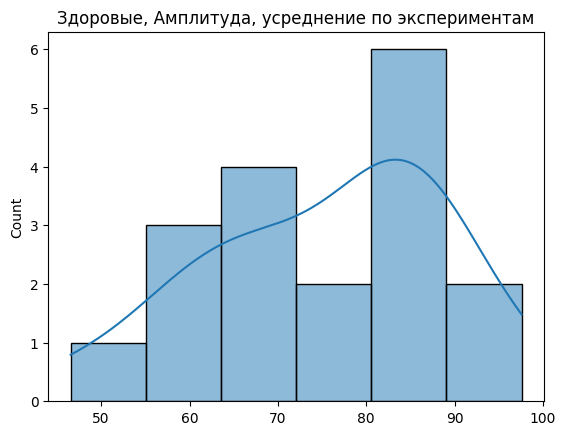

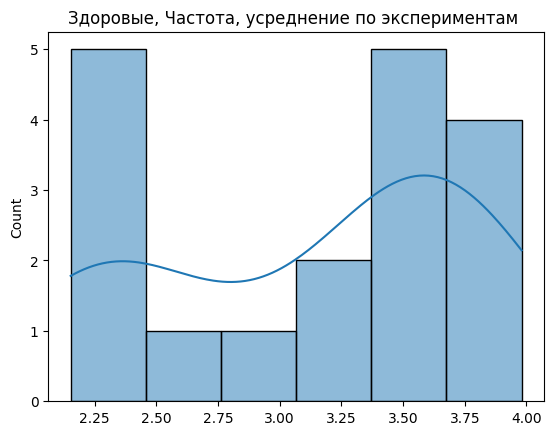

In [193]:
plt.figure()
plt.title('Здоровые, Амплитуда, усреднение по экспериментам')
sns.histplot(df_zdorov_usred_po_m['Амп_min_max_1'].values, kde = True)
plt.figure()
plt.title('Здоровые, Частота, усреднение по экспериментам ')
sns.histplot(df_zdorov_usred_po_m['Частота_1'].values, kde = True)
plt.show()

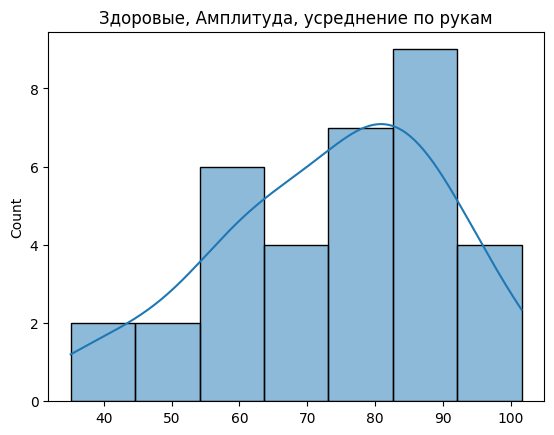

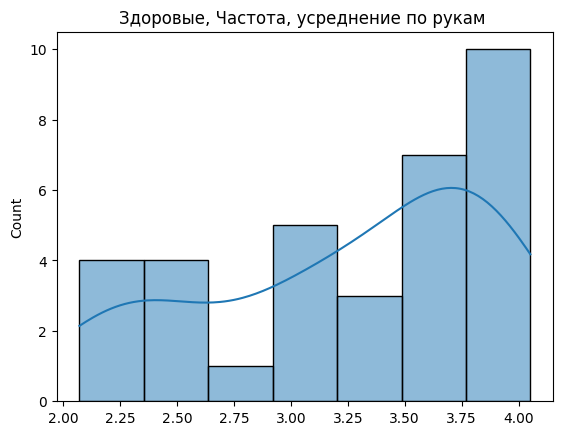

In [191]:
plt.figure()
plt.title('Здоровые, Амплитуда, усреднение по рукам')
sns.histplot(df_zdorov_usred_po_rukam['Амп_min_max_1'].values, kde = True)
plt.figure()
plt.title('Здоровые, Частота, усреднение по рукам ')
sns.histplot(df_zdorov_usred_po_rukam['Частота_1'].values, kde = True)
plt.show()

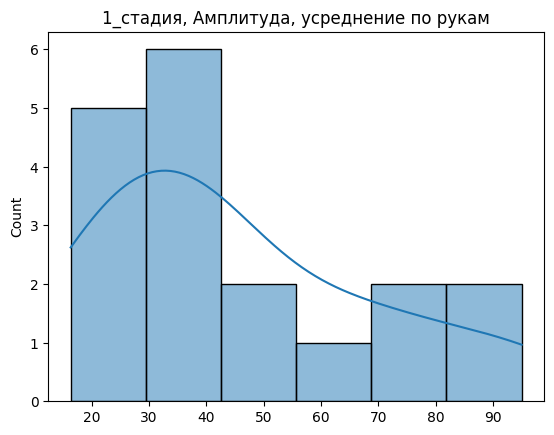

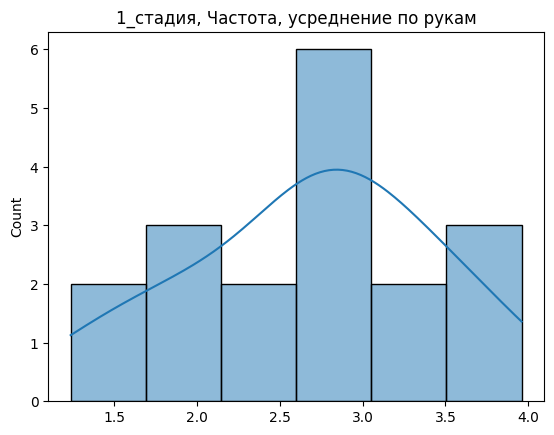

In [192]:
plt.figure()
plt.title('1_стадия')
plt.title('1_стадия, Амплитуда, усреднение по рукам')
sns.histplot(df_1_stage_usred_po_rukam['Амп_min_max_1'].values, kde = True)
plt.figure()
plt.title('1_стадия, Частота, усреднение по рукам')
sns.histplot(df_1_stage_usred_po_rukam['Частота_1'].values, kde = True)
plt.show()

Задание 1


<Axes: ylabel='Count'>

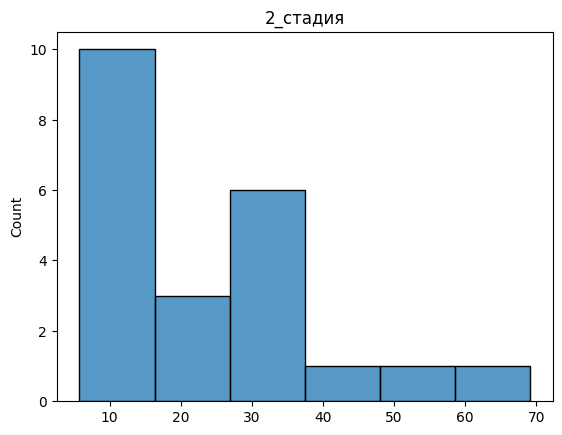

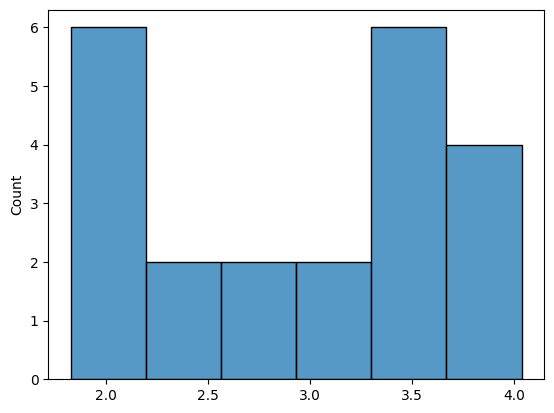

In [182]:
print('Задание 1')
plt.figure()
plt.title('2_стадия')
sns.histplot(df_2_stage_usred_po_rukam['Амп_min_max_1'].values)
plt.figure()
sns.histplot(df_2_stage_usred_po_rukam['Частота_1'].values)

In [ ]:
print('Task3')
for a in df_task3['Таргет'].unique():
    for b in df_task3['Таргет'].unique():
        if a!=b:
            buff1 = df_task3[df_task3['Таргет']== a]
            buff2 = df_task3[df_task3['Таргет']== b]
            _, amp = stats.ttest_ind(buff1['Амплитуда_min_max'].values, buff2['Амплитуда_min_max'].values, equal_var=False)
            _, amp1 = stats.ttest_ind(buff1['Амплитуда_median'].values, buff2['Амплитуда_median'].values, equal_var=False)
            _, freq = stats.ttest_ind(buff1['Частота'].values, buff2['Частота'].values, equal_var=False)
            print(f'Стадия {a} и стадия {b} по амплитуде_min_max' , amp, 'Выборки различимы' if amp<=p_value else 'Выборки неразличимы')
            print(f'Стадия {a} и стадия {b} по амплитуде_median' , amp1, 'Выборки различимы' if amp1<=p_value else 'Выборки неразличимы')
            print(f'Стадия {a} и стадия {b} по частоте' , freq, 'Выборки различимы' if freq<=p_value else 'Выборки неразличимы \n')

Task3
Стадия 0 и стадия 1 по амплитуде_min_max 5.810504903182284e-07 Выборки различимы
Стадия 0 и стадия 1 по амплитуде_median 1.2281653299675854e-10 Выборки различимы
Стадия 0 и стадия 1 по частоте 0.06381870887277223 Выборки различимы
Стадия 1 и стадия 0 по амплитуде_min_max 5.810504903182284e-07 Выборки различимы
Стадия 1 и стадия 0 по амплитуде_median 1.2281653299675854e-10 Выборки различимы
Стадия 1 и стадия 0 по частоте 0.06381870887277223 Выборки различимы
